# Technical demand response potential meta analysis - result comparison (overview)

**Puporse and background**: This notebook serves for evaluating the demand response potentials from different publications assessing technical demand response potentials for Germany. The data from the publications has been collected in order to carry out a meta analysis.

## Method applied
In the following, a brief description of the method applied is given for the sake of replicability.

### Selection of publications
Criterions for the selection of publications were:
* Regional focus: Federal republic of Germany
* Temporal restricitions: Publications until 2005
* Contents: technical demand response potentials
* Sectoral coverage: At least one of households, trade, commerce and services or industry assessed; no publications focusing on single appliances
* Own analysis carried out (no other meta analysis included)
* Inclusion of at least one of the parameters of interest (usually at least some information on potential in MW)

### Parameters assessed
Data for the following parameters was taken from the publications selected:
* eligibility: general eligibility of processes, applications or branches (demand response categories in the following) for load shifting, load shedding resp. (sole) load increase
* capacity-related parameters: capacity available for load shifting or load shedding, average, minimum and maximum load level, installed capacity as well as shiftable share of installed capacity
* time-reletad parameters: activation duration, interference duration, shifting duration, regenaration duration, maximum activations per year
* cost-related parameters: specific investments, variable costs (for activation), fixed costs

### Filtering and data collection
* A total of 70 publications has been selected in the first place in a literature research based on the titles, keywords and abstracts using terms like "Demand Response", "Demand Side Management", "Demand Side Integration", "load management", "load shifting", "load shedding", "potential", "Germany" as well as their German equivalents to formulate search strings. 
* Of these publications, 30 have met the above stated criteria and were further evaluated. 
* Because sometimes, several publications belonged to the same research project, these were grouped together resulting in 24 publication groups for which potential information has been evaluated.
* The data has been collected in an Excel Workbook ("Potenziale_Lastmanagement.xlsx"). The latest version of this Excel Workbook is evaluated with this notebook.
***
> _NOTE:_ 
> * _This notebook offers some room for improvement in terms of computing and coding efficiency._
> * _Pandas setting a value with a copy warning has been disabled. Instead, function definitions should be revised such that this is not necessary._

# Package imports
User-defined functions are imported in order to prevent redundancies:
* *extract_info*: extracts the information for the relevant parameter out of the complete input data
* *create_info_dict_for_years*: creates a dictionary for the relevant parameter info indexed by years
* *save_info_stats*: writes some info statistics into an Excel workbook
* *save_sources*: writes the sources information into an Excel workbook
* *get_nlargest*: determines the demand response categories with the largest potential
* *create_info_boxplot*: creates a box plot to visualize the parameter information
* *extract_stats*: determines some statistical measures of central tendency for a demand response paramter
* *create_projection_boxplot*: creates a box plot for future projections
* *save_future_sources*: writes the sources for future projections into an Excel workbook

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xlrd
import xlsxwriter
from openpyxl import load_workbook, Workbook
from collections import defaultdict
import warnings

from potential_evaluation_funcs import (extract_info, create_info_dict_for_years, 
                                        save_info_stats, save_sources, create_info_boxplot,
                                        get_nlargest, extract_stats, create_projection_boxplot, 
                                        save_future_sources)

# Allow for chained assignments (see note above)
pd.options.mode.chained_assignment = None

# Parameter settings
Set some (mostly boolean) parameters here in order to ensure code adaptability to future versions of potential collection (Excel workbook).
The following parameters determine the general workflow:

| Parameter | Purpose |
| :-: | :- |
| *write_outputs* | If True, statistical information for demand response parameters is written to Excel files. |
| *write_sources* | If True, sources information is written to Excel files. |
| *presentation_stuff* | If True, some rearrangement of column order is done in order to create nicer box plot<br> visualizations which can be used for presentation slides (only for certain demand response parameters). |

Some of the parameters are used to control user-defined function behaviour. These are set centrally here, but may be adapted for individual function calls. The following boolean parameters control function behaviour:

| Parameter | Purpose | Comment |
| :-: | :- | :- |
| *drop* | If True, all processes for which no information on a certain parameter is available will not be shown in the boxplots |
| *drop_datalack* | If True, all processes with less than 3 entries for a given parameter will be excluded. |
| *sample_stats* | If True, info on sample size will be calculated based on the data and shown in boxplots. | _Warning: activation leads to relatively high computational effort._ |
| *add_sources* | If True, source information for the data is collected. | _Warning: activation leads to relatively high computational effort._ |
| *modify_categories* | If True, the original demand response categories from the studies are replaced with self-defined demand response categories in order to aggregate them. There is the possibility to choose, how granular the aggregation will be. | _Warning: activation leads to relatively high computational effort._ |
| *aggregation_mode* | - Defines, how strongly the data will be aggregated if modify_categories is set to True.<br>- A broader aggregation increases the sample sizes but is more inaccurate since the underlying assumption in the grouping done here is that the profiles are identical.<br>- Options: "granular" which performs a decent aggregation vs. "broad" which combines lots of processes and applications into one category. |

The following parameters control plot ouputs:

| Paraneter | Purpose | Comment |
| :-: | :- | :- |
| *use_limits* | If True, the limits for the boxplot yaxis values are obtained from the data itself<br>(overall minimum / maximum in DataFrame to plot). | _Note: If parameter is set to True, yaxis limits given by the function<br>parameter ylim will be ignored._ |
| *use_colors* | If True, color will be chosen for a given process. |
| *show_title* | If True, the title for boxplots will be displayed. |
| *swarmplot* | If True, a bee swarm plot will be plotted on top of the boxplots<br>(using seaborn for plotting). |
| *savefig* | If True, boxplots are saved to .png files. |

The following parameters control process selection:

| Parameter | Purporse |
| :-: | :- |
| metric | Determines which metric shall be used to select processes for further analysis (median, mean, etc.) |
| n | Determines the n largest values for a certain metric to be further analyzed. |
| use_nlargest_cols | - If True, the processes resp. applications with the highest potentials are evaluated in the potential outlook.<br>- If False, a set of processes resp. applications is chosen that has been self-defined (instead of changing every single function parameter).<br>- If further options shall be incorporated, replace with a dict holding these options instead. |

> _NOTE: For usage within the clustering notebooks, the following parameter settings are needed to create the correct parameter statistics outputs which are read in in the clustering process:_
> * *write_outputs=True*
> * *drop=True*
> * *drop_datalack=True*
> * *modify_categories=True*
> * *aggregation_mode='granular'*

The remainder of the parameters is only relevant for controlling the plots and sources information in this notebook and can be freely chosen.

In [2]:
# Set paths and filenames for in- and outputs
path_folder_in = "./"
path_folder_out = "./out/"
path_folder_stats = path_folder_out + "stats/"
path_folder_sources = path_folder_out + "sources/"
path_folder_plots = path_folder_out + "plots/"

filename = "Potenziale_Lastmanagement.xlsx"
# If no sources are added, columns containing information on sources are ignored
filename_colnames = "Columns.xlsx"

# boolean parameters for controlling the workflow
write_outputs = True
write_sources = False
presentation_stuff = False

# boolean parameters for controlling function behaviour
drop = True
drop_datalack = True
sample_stats = True
add_sources = False
# Determine aggregation_mode if modify_categories is set to True
modify_categories = True
# Alternatives for aggregation mode: "granular" vs. "broad"
aggregation_mode = "granular" 

# boolean parameters for controlling plot outputs
use_limits = True
use_colors = True          
show_title = False
swarmplot = True
savefig = False

# parameters for process selection for further analysis
metric = "50%"
n = 5
use_nlargest_cols = False

is_renamed = False

Configure the fontsizes for matplotlib objects

In [3]:
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 15

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)    # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# Read in data
* Read in the Excel Workbook containing all data
* create a separate DataFrame with the potential information for every publication (which will be sliced and combined with the respective potential information from other studies in order to evaluate the respective parameter / appliance).

In [4]:
# Get all sheet names using xlrd
xls = xlrd.open_workbook(path_folder_in+filename, on_demand=True)
table_names = xls.sheet_names()

# Remove all sheets that do not contain potential information as well as worksheets from publications which
# were excluded in the process and include sheets "Dropdown" and "Kategorien"
removed_names = {el for el in table_names if len(el) > 6}

# Two publications were excluded in the latter process
# The worksheets were not removed but hided, hence, have to be removed here
removed_names.add("Stoe12")
removed_names.add("Bel15")
table_names = [el for el in table_names if el not in removed_names]

# The worksheets dropdown (containing all feasible dropdown options), categories (containing processes) 
# and colors (containing a color mapping for processes) shall be evaluated, too
table_names.append("Dropdown")
table_names.append("Kategorien")
table_names.append("Farben")
print(table_names)

['Ape12', 'Ary17', 'Blu13', 'Foc11', 'Gil15', 'Gob12', 'Gro13', 'Gru17', 'Haa17', 'Hen15', 'Klo09', 'Klo13', 'Krz13', 'Lad18', 'Lan15', 'Lie15', 'Mol10', 'Pau11', 'Pel16', 'r2b14', 'Roo10', 'Sta06', 'Ste17', 'Sty15', 'Farben', 'Dropdown', 'Kategorien', 'Farben']


In [5]:
# Read in data using pandas and parse it to individual DataFrames for each publication
xls = pd.ExcelFile(path_folder_in+filename)

ape12 = xls.parse("Ape12")
ary17 = xls.parse("Ary17")
blu13 = xls.parse("Blu13")
foc11 = xls.parse("Foc11")
gil15 = xls.parse("Gil15")
gob12 = xls.parse("Gob12")
gro13 = xls.parse("Gro13")
gru17 = xls.parse("Gru17")
haa17 = xls.parse("Haa17")
hen15 = xls.parse("Hen15")
klo09 = xls.parse("Klo09")
klo13 = xls.parse("Klo13")
krz13 = xls.parse("Krz13")
lad18 = xls.parse("Lad18")
lan15 = xls.parse("Lan15")
lie15 = xls.parse("Lie15")
mol10 = xls.parse("Mol10")
pau11 = xls.parse("Pau11")
pel16 = xls.parse("Pel16")
r2b14 = xls.parse("r2b14")
roo10 = xls.parse("Roo10")
sta06 = xls.parse("Sta06")
ste17 = xls.parse("Ste17")
sty15 = xls.parse("Sty15")

# Read in dropdown options, categories as well as colors used, as well
dropdown = xls.parse("Dropdown")
if aggregation_mode == "granular":
    categories = xls.parse("Kategorien")
elif aggregation_mode == "broad":
    categories = xls.parse("Kategorien_grob")
colors = xls.parse("Farben", index_col=0, header=0)

# Prepare data for further analysis
In the following, some data preparation steps are carried out in order to harmonize the data basis and ensure further usability.

## General routines
The following general routines introduce dicts to easily adress all sheets / DataFrames using for loops. Furthermore, the years considered are grouped in order to distinct status quo considerations from projections for the future. Furthermore, the data basis is split up by sectors and years since this is often needed in the following.

### Publications dict (shortcut)
Introduce a dict matching the DataFrames to a string name for quicker handling

In [6]:
publications_dict = {
    "Ape12": ape12,
    "Ary17": ary17,
    "Blu13": blu13,
    "Foc11": foc11,
    "Gil15": gil15,
    "Gob12": gob12,
    "Gro13": gro13,
    "Gru17": gru17,
    "Haa17": haa17,
    "Hen15": hen15,
    "Klo09": klo09,
    "Klo13": klo13,
    "Krz13": krz13,
    "Lad18": lad18,
    "Lan15": lan15,
    "Lie15": lie15,
    "Mol10": mol10,
    "Pau11": pau11,
    "Pel16": pel16,
    "r2b14": r2b14,
    "Roo10": roo10,
    "Sta06": sta06,
    "Ste17": ste17,
    "Sty15": sty15
}

### Years
Evaluate the years for which potentials are given in order to group them into the following groups:
* Status quo: prior to 2020
* 2020
* 2025 (including 2023)
* 2030
* 2035
* 2040
* 2045
* 2050

In [7]:
# Get the years for which potentials are given
set_years = set()

for k, v in publications_dict.items():
    for el in v["Jahr"].unique():
        set_years.add(el)

# Define two groups of years (for potential evaluation)
status_quo_years = {el for el in set_years if el < 2020}
years_2025 = {2023, 2025}

# Define year dict for checking the year (group)
years_dict = {
    "SQ": status_quo_years,
    "2020": [2020],
    "2025": years_2025,
    "2030": [2030],
    "2035": [2035],
    "2040": [2040],
    "2045": [2045],
    "2050": [2050]
}

### Processes
Obtain sets of processes from Excel workbook:
* processes_original: Original listing of processes
* processes_categorized: Categorization of processes (same as in method comparison)

In [8]:
# Original set of processes
processes_original = set(dropdown["Prozess"].values)

# Categorized set of processes
cat1 = categories["Prozesskategorie 1"].values
cat2 = categories["Prozesskategorie 2"].dropna().values
cat3 = categories["Prozesskategorie 3"].dropna().values
processes_categorized = set(np.concatenate((cat1, cat2, cat3), axis = 0))

# Compare the number of processes before and after adjusting the categorization
print(len(processes_original), len(processes_categorized))

99 68


In [9]:
categories.head()

,Prozess (ursprüngliche Kategorien),Prozesskategorie 1,Prozesskategorie 2,Prozesskategorie 3,Einstufung,Nutzung Prozesskategorie 1
0,Chlor-Alkali-Elektrolyse,Chlor-Alkali-Elektrolyse,-,-,Prozess,1
1,Luftzerlegung,Luftzerlegung,-,-,Prozess,1
2,Primäraluminiumelektrolyse,Primäraluminiumelektrolyse,-,-,Prozess,1
3,Primärkupferherstellung,Kupfer- und Zinkherstellung (Elektrolyse),-,-,Prozess,1
4,Zinkelektrolyse,Kupfer- und Zinkherstellung (Elektrolyse),-,-,Prozess,1


### Publications per sector and year (dict as shortcut)
* Create DataFrames (subsets of overall data tables) which focus on a certain sector and year and store them in a dict indexed by publications and years resp. year groups
* Include the adjusted process categorization in order to be able to use this for evaluation as well
    * This operation is more or less equivalent to assigning the process categorization in the original data set which could be achieved using the Excel function VLOOKUP (SVERWEIS in German).
    * It is implemented by merging the two DataFrames to a combined one since the indices differ and thus cannot be used for comparison.

In [10]:
publications_ind_years_dict = {}
publications_tcs_years_dict = {}
publications_hoho_years_dict = {}

for year_key, years in years_dict.items():
    for k, v in publications_dict.items():
        # Extract data for the industry sector
        publications_ind_years_dict[k+"_"+year_key] = v[(v["Sektorenzuordnung"] == "Industrie") & (v["Jahr"].isin(years))]
        publications_ind_years_dict[k+"_"+year_key]["year_key"] = year_key
        publications_ind_years_dict[k+"_"+year_key] = \
            pd.merge(publications_ind_years_dict[k+"_"+year_key], categories, left_on="Prozess", right_on="Prozess (ursprüngliche Kategorien)", how="inner").drop("Prozess (ursprüngliche Kategorien)", axis=1)
        
        # Extract data for the trade, commerce and services sector
        publications_tcs_years_dict[k+"_"+year_key] = v[(v["Sektorenzuordnung"] == "GHD") & (v["Jahr"].isin(years))]
        publications_tcs_years_dict[k+"_"+year_key]["year_key"] = year_key
        publications_tcs_years_dict[k+"_"+year_key] = \
            pd.merge(publications_tcs_years_dict[k+"_"+year_key], categories, left_on="Prozess", right_on="Prozess (ursprüngliche Kategorien)", how="inner").drop("Prozess (ursprüngliche Kategorien)", axis=1)
        
        # Extract data for the household sector
        publications_hoho_years_dict[k+"_"+year_key] = v[(v["Sektorenzuordnung"] == "Haushalte") & (v["Jahr"].isin(years))]
        publications_hoho_years_dict[k+"_"+year_key]["year_key"] = year_key
        publications_hoho_years_dict[k+"_"+year_key] = \
            pd.merge(publications_hoho_years_dict[k+"_"+year_key], categories, left_on="Prozess", right_on="Prozess (ursprüngliche Kategorien)", how="inner").drop("Prozess (ursprüngliche Kategorien)", axis=1)

### Prepare demand response categories for further analysis
Due to the heterogenous demand response categories used, a harmonization / an own categorization is needed.
This is done by a mapping of original process resp. demand response category names to self-chosen ones (derived from the categories of the meta-analysis and mostly on a basis of processes / applications). 

Some original categories have to be grouped together. If this is the case, their availability profiles are assumed to be (more or less) identical. Then, aggregation rules are applied to the demand response parameters (sum resp. (weigthed) average).

For the decision, whether to just replace the original demand response category name or whether to apply aggregation rules, a variable *replacement_mode* is introduced:
* -1: Keep original column name since there is no equivalent alternative
* 0: Take column name from "Prozesskategorie 1" -> no duplicates (simple renaming)
* 1: Replace multiple columns with one value of "Prozesskategorie 1" -> duplicates (aggregation is carried out)

The replacement_mode is set here based on a prior visual inspection of the used categories (uncomment lines at the bottom to see the output).

In [11]:
# Industry sector

if aggregation_mode == "granular":
    # dict holding the entries to be changed to 1
    replacement_dict = {"Blu13_SQ": [5, 6],
                        "Gil15_SQ": [2, 3],
                        "Klo09_SQ": [3, 4],
                        "Lad18_SQ": [2, 3],
                        "Gil15_2020": [2, 3],
                        "Klo09_2020": [2, 3],
                        "Gil15_2030": [2, 3],
                        "Gil15_2050": [2, 3]}

    # dict holding the entries to be changed to -1
    keep_dict = {"Lan15_SQ": [0, 4],
                 "r2b14_SQ": [1]}

elif aggregation_mode == "broad":
    # dict holding the entries to be changed to 1
    replacement_dict = {"Ape12_SQ": [2, 3],
                        "Blu13_SQ": [5, 6],
                        "Foc11_SQ": [2, 3, 4, 5],
                        "Gil15_SQ": [2, 3, 4, 5, 6],
                        "Gru17_SQ": [2, 3],
                        "Klo09_SQ": [3, 4, 5, 6, 7, 8],
                        "Klo13_SQ": [2, 3],
                        "Lad18_SQ": [2, 3],
                        "Mol10_SQ": [4, 8, 9],
                        "Pel16_SQ": [2, 3, 6, 10],
                        "Ste17_SQ": [9, 10, 11],
                        "Ape12_2020": [2, 3],
                        "Gil15_2020": [2, 3, 4, 5, 6],
                        "Gru17_2020": [2, 3],
                        "Klo09_2020": [2, 3, 4, 5, 6, 7],
                        "Pel16_2020": [2, 3],
                        "Ste17_2020": [9, 10, 11],
                        "Gru17_2025": [2, 3],
                        "Pel16_2025": [2, 3],
                        "Ste17_2025": [9, 10, 11],
                        "Ape12_2030": [2, 3],
                        "Gil15_2030": [2, 3, 4, 5, 6],
                        "Gru17_2030": [2, 3],
                        "Pel16_2030": [2, 3],
                        "Ste17_2030": [9, 10, 11],
                        "Ste17_2035": [9, 10, 11],
                        "Ste17_2040": [9, 10, 11],
                        "Ste17_2045": [9, 10, 11],
                        "Gil15_2050": [2, 3, 4, 5, 6],
                        "Ste17_2050": [9, 10, 11]}

    # dict holding the entries to be changed to -1
    keep_dict = {"Lan15_SQ": [0, 4],
                 "r2b14_SQ": [1]}

# Change the replacement_mode for the above stated entries
for k, v in publications_ind_years_dict.items():
    v["replacement_mode"] = 0
    if k in replacement_dict.keys():
        v.loc[replacement_dict[k], "replacement_mode"] = 1
    if k in keep_dict.keys():
        v.loc[keep_dict[k], "replacement_mode"] = -1
    
    #print(k)    
    #display(v.loc[:,["Prozess", "Prozesskategorie 1", "replacement_mode"]])

In [12]:
# TCS sector

if aggregation_mode == "granular":
    # dict holding the entries to be changed to 1
    replacement_dict = {"Foc11_SQ": [0, 4],
                        "Gil15_SQ": [0, 1, 2],
                        "Klo09_SQ": [0, 1, 3, 4, 5, 6],
                        "Gil15_2020": [0, 1, 2],
                        "Klo09_2020": [0, 1, 3, 4, 5, 6],
                        "Gil15_2030": [0, 1, 2],
                        "Gil15_2050": [0, 1, 2]}

    # dict holding the entries to be changed to -1
    keep_dict = {}
    
elif aggregation_mode == "broad":
    # dict holding the entries to be changed to 1
    replacement_dict = {"Foc11_SQ": [0, 4],
                        "Gil15_SQ": [0, 1, 2],
                        "Klo09_SQ": [0, 1, 2, 3, 4, 5, 6],
                        "Gil15_2020": [0, 1, 2],
                        "Klo09_2020": [0, 1, 2, 3, 4, 5, 6],
                        "Gil15_2030": [0, 1, 2],
                        "Gil15_2050": [0, 1, 2]}

    # dict holding the entries to be changed to -1
    keep_dict = {}

# Change the replacement_mode for the above stated entries
for k, v in publications_tcs_years_dict.items():
    v["replacement_mode"] = 0
    if k in replacement_dict.keys():
        v.loc[replacement_dict[k], "replacement_mode"] = 1
    if k in keep_dict.keys():
        v.loc[keep_dict[k], "replacement_mode"] = -1   
    
    #print(k)    
    #display(v.loc[:,["Prozess", "Prozesskategorie 1", "replacement_mode"]])

In [13]:
# Household sector

if aggregation_mode == "granular":
    # dict holding the entries to be changed to 1
    replacement_dict = {}

    # dict holding the entries to be changed to -1
    keep_dict = {"Gro13_SQ": [0],
                "Klo13_SQ": [2],
                "Mol10_SQ": [6],
                "Pel16_SQ": [4],
                "Sta06_SQ": [6],
                "Mol10_2020": [6],
                "Pel16_2020": [4],            
                "Pel16_2025": [4],            
                "Pel16_2030": [4]}

elif aggregation_mode == "broad":
    # dict holding the entries to be changed to 1
    replacement_dict = {"Ape12_SQ": [0, 7, 9],
                        "Ary17_SQ": [4, 5],
                        "Haa17_SQ": [0, 1, 2],
                        "Klo09_SQ": [3, 4],
                        "Mol10_SQ": [4, 5],
                        "Sta06_SQ": [1, 2],
                        "Ste17_SQ": [1, 4],
                        "Sty15_SQ": [0, 1],
                        "Ape12_2020": [0, 7, 9],
                        "Klo09_2020": [3, 4],
                        "Mol10_2020": [4, 5],
                        "Ste17_2020": [1, 4],
                        "Ste17_2025": [1, 4],
                        "Sty15_2025": [0, 1],
                        "Ape12_2030": [0, 7, 9],
                        "Ste17_2030": [1, 4],
                        "Ste17_2035": [1, 4],
                        "Ste17_2040": [1, 4],
                        "Ste17_2045": [1, 4],
                        "Ste17_2050": [1, 4],
                        "Sty15_2050": [0, 1]}

    # dict holding the entries to be changed to -1
    keep_dict = {"Gro13_SQ": [0],
                "Klo13_SQ": [2],
                "Mol10_SQ": [6],
                "Pel16_SQ": [4],
                "Sta06_SQ": [6],
                "Mol10_2020": [6],
                "Pel16_2020": [4],            
                "Pel16_2025": [4],            
                "Pel16_2030": [4]}

# Change the replacement_mode for the above stated entries
for k, v in publications_hoho_years_dict.items():
    v["replacement_mode"] = 0
    if k in replacement_dict.keys():
        v.loc[replacement_dict[k], "replacement_mode"] = 1
    if k in keep_dict.keys():
        v.loc[keep_dict[k], "replacement_mode"] = -1  
    
    #print(k)    
    #display(v.loc[:,["Prozess", "Prozesskategorie 1", "replacement_mode"]])

### Prepare colors
Include the values for "Prozesskategorie 1" from the categories DataFrame (and exclude duplicates).

In [14]:
# Include values of "Prozesskategorie 1" from the categories DataFrame in the color mapping
new_colors = colors.copy()
new_colors["Prozesskategorie 1"] = categories.set_index("Prozess (ursprüngliche Kategorien)")["Prozesskategorie 1"]

new_colors = new_colors.set_index("Prozesskategorie 1")
new_colors = new_colors.loc[~new_colors.index.duplicated(keep="first")]
new_colors.index.name = "Prozess"

# concat original colors DataFrame with the one containing values for "Prozesskategorie 1"
# and remove duplicates
colors = pd.concat([colors, new_colors])
colors = colors.loc[~colors.index.duplicated(keep="first")]

# Show colors
colors

,Farbe (matplotlib strings)
Prozess,
Chlor-Alkali-Elektrolyse,mediumturquoise
Luftzerlegung,cornflowerblue
Primäraluminiumelektrolyse,darkorange
Primärkupferherstellung,goldenrod
Zinkelektrolyse,gray
...,...
Hybrid-Wärmeerzeugungssysteme (Widerstandserhitzer / Wärmepumpe + Erdgas-Brennwertkessel),coral
Haushalte gesamt,black
Elektromobilität,orange


**NEW COLOR MAPPING - REMOVE OLD VERSION ABOVE**

In [15]:
colors = xls.parse("Farben_neu", index_col=0, header=0)

In [16]:
colors

,Farbe (matplotlib strings)
Prozesskategorie,
Chlor-Alkali-Elektrolyse,mediumturquoise
Luftzerlegung,cornflowerblue
Primäraluminiumelektrolyse,darkorange
Kupfer- und Zinkherstellung (Elektrolyse),goldenrod
Holz- und Zellstoffherstellung,peru
...,...
Power-to-Heat,mistyrose
Elektrische Öfen,rosybrown
elektrische Direktheizungen,lightsalmon


## Prepare column names
Column names have to be carefully selected and harmonized in order to be able to compare potential information on a common basis. This holds especially for evaluating capacity-related parameters.
* Get capacity-related columns:
    * Evaluate all columns holding the word "potential" or fractions of it.
    * Distinct between pos and negative potentials.
    * Remove columns evaluating sociotechnical instead of technical potentials as well as those evaluating energy instead of capacity.

Inspect columns by evaluating all column names used accross the publications

In [17]:
# initialize an empty throwaway array
help_array = np.empty(shape=(0,))

# add all column values and convert to a set to remove duplicates
for k, v in publications_dict.items():
    help_array = np.concatenate((help_array, v.columns.values), axis = 0)
    
all_cols = set(help_array)

In [18]:
# print the number of different column names used accross the publications
len(all_cols)

385

Prepare columns for further usage:
* The list of all columns used has been transferred to an Excel workbook using the following commented lines of code.
* The columns have been matched to one parameter for evaluation by going through them and assigning a parameter (has been done manually using Excel).
* The manipulated Excel workbook ("Columns.xlsx") is read in in the following again to be able to use the grouping applied.

In [19]:
# Uncomment this cell and reassign groups if changes to the columns in the data collection occur.
#all_cols_Series = pd.Series(data=sorted(list(all_cols)))
#all_cols_Series.to_excel("Columns.xlsx", encoding="utf-8-sig", header=False)

In [20]:
all_cols_df = pd.read_excel(path_folder_in+filename_colnames, index_col=0)

In [21]:
# Assign the groups that have been defined to a variable to use it as key for a dict
groups = all_cols_df["Gruppe"].unique()
groups

array(['Aktivierungsdauer', 'variable Kosten', 'keine', 'fixe Kosten',
       'Zeitverfügbarkeit', 'Durchschnittsleistung',
       'Durchschnittsauslastung', 'Investitionsausgaben', 'Lasterhöhung',
       'Lastverschiebung', 'Lastverzicht', 'Maximallast',
       'Minimalauslastung', 'Minimallast', 'Potenzial negativ Mittel',
       'Potenzial negativ min', 'Potenzial negativ max',
       'Potenzial positiv Mittel', 'Potenzial positiv min',
       'Potenzial positiv max', 'Regenerationsdauer',
       'Schaltdauer positiv', 'Schaltdauer negativ', 'Stromverbrauch',
       'Verschiebedauer', 'Wirkungsgrad', 'installierte Leistung',
       'maximale Abrufhäufigkeit pro Jahr',
       'maximale Abrufhäufigkeit pro Woche',
       'flexibilisierbarer Leistungsanteil', 'Jahr', 'Maximalauslastung',
       'Potenzial positiv Mittel Lastverzicht',
       'Potenzial positiv max Lastverzicht',
       'Potenzial positiv min Lastverzicht', 'Prozess',
       'Schaltdauer positiv Lastverzicht', 'Sektoren

In [22]:
cols_dict = {}

for key in groups:
    cols_dict[key] = list(all_cols_df[all_cols_df["Gruppe"] == key].index.values)
    #cols_dict[key].extend(["Prozesskategorie", "Jahr", "Sektorenzuordnung", "study"])

swapped_cols_dict = {val: k for k, v in cols_dict.items() for val in v}

# Prepare data for further analyses (NEW)
Experimental section:
* Use simple DataFrame filtering instead of creating extensive dict structures
* TODO: Resume when time permits / Remove if not!

## Create an overall parameter data set with all information
Combine all DataFrames created from the Excel sheets of the dfferent studies into a single one holding all the information:
* Filter cols that don't need renaming (columns used for filtering etc.)
* Rename the other columns: Append the string for the study to the name in oder not to loose information in aggregation
* Loop over the publications dict and concat the individual DataFrames in order to form one overall DataFrame that is used to flter the needed information in the following
* Add the study string to all columns containing sources infomation (i.e. all containing the German string 'Fundstelle')
* Merge the overall parameters data set with the process categories used for grouping

In [23]:
cols_not_to_rename = [
    "Prozess", "Sektorenzuordnung", "Jahr", 
    "Lastverschiebung", "Lastverzicht", "Lasterhöhung", 
    "study"
]
cols_not_to_rename.extend([
    col for col in all_cols if "Fundstelle" in col
])

In [24]:
parameters = pd.DataFrame()
if not is_renamed:
    for k, v in publications_dict.items():
        v["study"] = k

        cols_to_rename = {
            col: col + "_" + k for col in v.columns 
            if col not in cols_not_to_rename
        }
        for col, renamed_col in cols_to_rename.items():
            swapped_cols_dict[renamed_col] = swapped_cols_dict[col] 

        v.rename(columns=cols_to_rename, inplace=True)

        parameters = pd.concat([parameters, v])

    for el in parameters.columns:
        if "Fundstelle" in el:
            parameters[el] = (
                parameters["study"].values 
                + ": " 
                + parameters[el].astype(str).values
            )
    
    is_renamed = True

In [25]:
cats_new = xls.parse("Kategorien_neu")

In [26]:
parameters = pd.merge(
    parameters, cats_new,
    left_on="Prozess", 
    right_on="Prozess (ursprüngliche Kategorien)",
    how="left"
)

## Aggregate data by process categories
Determine aggregation rules:
* For original columns, aggregation rules are given in the "Columns.xlsx" mapping specified. Columns not to be used are assigned a value of "drop" and neglected.
* For the modified columns including the study shorthand symbol, an assignment is made based on the predefined mapping, whereby all sources columns - those with the string "Fundstelle" in it - are assigned the sum as aggregation rule.
* In order not to create a lot of 0 entries by aggregating NaN values (which is the default behaviour), aggregation rule sum is replaced by a lambda function requiring a `min_count` of 1, i.e. at least of entry being notnull.

In [27]:
agg_dict = all_cols_df["Aggregationsregel"].loc[
    all_cols_df["Aggregationsregel"] != "drop"
].to_dict()
agg_dict["study"] = "first"

new_agg_dict = {}
for col in parameters.columns:
    for k, v in agg_dict.items():
        if k in col:
            if not "Fundstelle" in col:
                new_agg_dict[col] = v
            else:
                new_agg_dict[col] = lambda x: x.sum(min_count=1)

In [28]:
reversed_agg_dict = defaultdict(list)
for k, v in new_agg_dict.items():
    reversed_agg_dict[v].append(k)
    
for k in reversed_agg_dict["sum"]:
    new_agg_dict[k] = lambda x: x.sum(min_count=1)

Group by process category within studies in order to remove duplicates:
* Define a filter for the sectors. For studies and years, existing dictionaries can be used.
* Iterate over studies, sectors and years; _Note: This operation is quite expensive, but only needed once here_
* Filter DataFrame accordingly and groupby "Prozesskategorie" to remove duplicates

In [29]:
# Define sector filter
filter_sector = {
    "ind": "Industrie",
    "tcs": "GHD",
    "hoho": "Haushalte"
}

In [30]:
grouped = pd.DataFrame()
for study in publications_dict.keys():
    for sector, sector_filter in filter_sector.items():
        for year_key, year_value in years_dict.items():
            
            filtered = parameters.loc[
                (parameters["study"] == study)
                & (parameters["Sektorenzuordnung"] == sector_filter)
                & (parameters["Jahr"].isin(year_value))
            ].dropna(axis=1, how="all")
            
            if not filtered.empty:
            
                filtered = filtered.groupby("Prozesskategorie").agg({
                    k: v for k, v in new_agg_dict.items() if k in filtered.columns
                })
                grouped = pd.concat([grouped, filtered])

## Define functions for structuring the (repeated) analyses
**_TODO: Move to dedicated .py file!_**

In [31]:
def extract_info(df, swapped_cols_dict, parameters, sector, years_dict, year):
    """Extract info for (a) given parameter(s), sector and year from data
    
    Parameters
    ----------
    df : pandas.DataFrame
        grouped overall data set
    
    swapped_cols_dict : dict
        dict mapping cols to the parameter group of interest
    
    parameters : str or list
        parameter group to extract data for
    
    sector : str
        Sector to look for;
        possible values are "ind", "tcs" and "hoho"
    
    years_dict : dict
        dict holding all possible years
    
    year : str
        Year to extract data for; must be a key of years_dict;
        possible values are "SQ", "2020", "2025", "2030", "2035", 
        "2040", "2045" and "2050"
        
    Returns
    -------
    filtered_df : pandas.DataFrame
        Data set fltered for parameter(s) of interest
    """
    # Filter for sector, year and parameter and determine cols to use
    if isinstance(parameters, str):
        parameter = parameters
        parameters = []
        parameters.append(parameter)
    elif not isinstance(parameters, list):
        raise TypeError(
            "parameters must be of type str (single parameter) "
            "or list (multiple parameters)."
        )
    
    filtered_df = df.loc[
        (df["Sektorenzuordnung"] == filter_sector[sector]) 
        & (df["Jahr"].isin(years_dict[year]))
    ]
    
    cols_to_use = []
    for parameter in parameters:
        cols_to_use.extend([
            col for col in filtered_df.columns
            if col in swapped_cols_dict.keys()
            and swapped_cols_dict[col] == parameter
        ])
    cols_to_use = list(set(cols_to_use))
    sources_cols = [
        col for col in cols_to_use if "Fundstelle" in col
    ]
    
    # Filter for all nan rows and drop them
    filtered_df.set_index("study", append=True, inplace=True)
    nan_idx = filtered_df.loc[
        filtered_df[
            [
                col for col in cols_to_use 
                if col not in sources_cols
            ]
        ].isnull().all(1)].index    
    filtered_df.drop(nan_idx, inplace=True)
    filtered_df.reset_index(level=1, drop=False, inplace=True)
    
    cols_to_use.extend(["Jahr", "Sektorenzuordnung", "study"])
    filtered_df = filtered_df[cols_to_use]
    
    return filtered_df

In [32]:
def add_value_counts_and_sources(filtered_df, drop_data_lack=True):
    """Add value counts to a filtered parameter data set
    
    Parameters
    ----------
    filtered_df : pandas.DataFrame
        Data set filtered for the parameter(s) of interest
    
    drop_data_lack : boolean
        If True, drop data sets where less than 3 data points exist
        
    Returns
    -------
    filtered_df : pandas.DataFrame
        Data set filtered for the parameter(s) of interest including
        information on the number of studies that contain values for this /
        these parameter(s) as well as the number of data points per
        process category
    """
    # Count number of publications by counting indices
    filtered_df["number_publications"] = filtered_df.index.value_counts()
    
    # Count not null entries for each study and aggregate by process category
    sources_cols = [
        col for col in filtered_df.columns if "Fundstelle" in col
    ]
    filtered_df["number_entries"] = (
        filtered_df.count(axis=1) 
        - (len(sources_cols) 
           + len(["Jahr", "Sektorenzuordnung", "study", "number_publications"]))
    )
    entries = filtered_df["number_entries"].groupby(filtered_df.index).sum()
    filtered_df["abs_number_entries"] = entries
    filtered_df.drop(columns=["number_entries"], inplace=True)
    
    if drop_data_lack:
        filtered_df = filtered_df.loc[filtered_df["abs_number_entries"] >= 3]
    
    # Join all the sources string information by process category
    for col in sources_cols:
        entries = filtered_df[col].groupby(filtered_df.index).apply(lambda x: "; ".join(x))
        filtered_df["all_sources_" + col] = entries
    
    return filtered_df

In [33]:
def groupby_process_category(filtered_df, agg_rule="mean"):
    """Group the filtered parameter data set by process categories
    
    Parameters
    ----------
    filtered_df : pandas.DataFrame
        Data set filtered for the parameter(s) of interest
        
    agg_rule : str
        Aggregation rule to apply; defaults to "mean"
        Since the parameters come with distinct columns, it actually has
        no effect. "mean" is preferred over "sum" since "sum" creates 0
        entries when aggregating only np.nan values
    
    Returns
    -------
    grouped_df : pandas.DataFrame
        Data set for parameter(s) of interested grouped by
        process categories
    """
    agg_rules = {
        col: agg_rule for col in filtered_df.columns 
        if not "all_sources" in col
        and not "Fundstelle" in col
        and col not in ["Jahr", "Sektorenzuordnung", "study"]
    }
    for col in filtered_df.columns:
        if "all_sources" in col:
            agg_rules[col] = lambda x: "; ".join(x)
    
    grouped_df = filtered_df.groupby(filtered_df.index).agg(agg_rules)
    
    return grouped_df

In [34]:
def transpose_and_split(grouped_df):
    """Transpose and split the grouped data set
    
    The DataFrame fed in is transposed and split into the actual
    numeric parameter data, the counts of the number of publications
    and data points as well as the combined sources information
    
    Parameters
    ----------
    grouped_df : pandas.DataFrame
        Data set for parameter(s) of interested grouped by
        process categories
        
    Returns
    -------
    numeric_df : pandas.DataFrame
        Data set containing the actual numeric parameter information
    
    count_df : pandas.DataFrame
        Data set containing the counts on the number of publications that
        contain information as well as the number of data points per process
        category
    
    all_sources_df : pandas.DataFrame
        Data set containing the combined sources information for 
        the parameter
    """
    transposed_df = grouped_df.T
    
    all_sources_rows = [
        row for row in grouped_df.columns
        if "all_sources" in row
    ]
    count_rows = ["number_publications", "abs_number_entries"]
    numeric_rows = [
        row for row in grouped_df.columns
        if row not in all_sources_rows
        and row not in count_rows
    ]
    
    numeric_df = transposed_df.loc[numeric_rows]
    numeric_df = numeric_df.astype("float64")
    count_df = transposed_df.loc[count_rows]
    all_sources_df = transposed_df.loc[all_sources_rows]
    
    return numeric_df, count_df, all_sources_df

In [35]:
def extract_sample_stats(
    numeric_df, 
    save=False, 
    path_folder="./out/stats/", 
    file_name="stats.csv", 
):
    """Extract the sample stats for the parameter data set
    
    Calculate statistical moments using the built-in 
    pandas.DataFrame.describe() method and add quantile 5%, 10%,
    90% and 95% to it.
    
    Parameters
    ----------
    numeric_df : pandas.DataFrame
        Data set containing the actual numeric parameter information
        
    save : boolean
        Save the extracted parameter statistics if True
    
    path_folder : str
        Path where to store the parameter statistics
    
    file_name : str
        File name to use for storing the parameter statistics
    
    sheet_name : str
        Sheet name to use / append
    
    Returns
    -------
    stats_df : pandas.DataFrame
        Data set containing statistics for the parameter(s)
    """
    if not numeric_df.empty:
        stats_df = numeric_df.describe()
        quantiles = {"5%": 0.05, "10%": 0.1, "90%": 0.9, "95%": 0.95}

        for key, val in quantiles.items():
            stats_df.loc[key] = numeric_df.quantile(val).values

        if save:        
            stats_df.to_csv(path_folder + file_name, sep=";", decimal=".")
    
        return stats_df

In [36]:
def extract_sample_sources(
    all_sources_df, 
    save=False, 
    path_folder="./out/sources/", 
    file_name="sources.csv"
):
    """Extract the sources for the parameter data set
    
    Parameters
    ----------
    all_sources_df : pandas.DataFrame
        Data set containing the combined sources information
        per pocess category
    
    save : boolean
        Save the combined sources information if True
    
    path_folder : str
        Path where to store the combined sources
    
    file_name : str
        File name to use for storing the combined sources
    
    sheet_name : str
        Sheet name to use / add
    
    Returns
    -------
    unique_sources_string : str
        Combined sources string
    """
    if not all_sources_df.empty:
        combined_sources = all_sources_df.agg(lambda x: "; ".join(x))
        combined_sources = combined_sources.values + "; "
        combined_sources_string = combined_sources.sum()

        unique_sources_set = set(combined_sources_string.split("; "))
        unique_sources_set.discard("")

        unique_sources_string = "; ".join(unique_sources_set)
        unique_sources_string = unique_sources_string.replace(".0", "")
        unique_sources_string = unique_sources_string.replace(": nan", "")

        if save:
            with open(path_folder + file_name, "w", encoding="UTF8") as opf:
                opf.write(unique_sources_string)

In [37]:
def create_boxplot(
    numeric_df,
    counts_df,
    year,
    title,
    ylabel,
    colors,
    ylim=[0, 3000],
    use_colors=False,
    use_limits=True, 
    swarmplot=False,
    savefig=False,
    show_title=True,
    path_folder="./out/plots/",
    file_name="parameter"
):
    """
    Function creates a boxplot for the relevant parameter, indexed by
    processes.
    
    Parameters
    ----------
    dict_info_years: dict or list of dicts
        Dictionary resp. dictionaries to store the info on the relevant 
        parameter, indexed by years
        
    year: str
        Year for which the plot shall be created
        
    title: str
        Title for the plot
    
    ylabel: str
        label for the yaxis
        
    colors: pd.DataFrame
        pd.DataFrame containing the category / color mapping
        
    ylim: list
        limits for the yaxis
        
    use_colors: boolean
        If True, colors from the given colors DataFrame will be used, default
        ones elsewhise

    use_limits: boolean
        If True, yaxis limits will be obtained from the extreme values of
        the data including some space
        
    sample_stats: boolean
        True if info on the sample size is included
    
    add_sources: boolean
        True if information on sources (page areas) is included
        
    swarmplot: boolean
        Create an overlay bee swarm plot if True using seaborn

    savefig: boolean
        Save figure to png if True
        
    show_title: boolean
        Show / hide the given title
        
    path_folder: str
        Path where the png file shall be stored
    
    filename: str
        Name of the png file to be stored    
    """
    # Terminate execution when DataFrame is entirely empty
    if numeric_df.empty:
        warnings.warn("No numeric data to plot.", UserWarning)
        return None

    fig, ax = plt.subplots(figsize=(15, 5))

    numeric_df_plot = numeric_df.rename(columns={
        col: col + ", n: " + str(
            int(counts_df.at["number_publications", col])
        ) + ", m: " + str(
            int(counts_df.at["abs_number_entries", col])
        )
        for col in counts_df.columns
    })

    if not swarmplot:
        _ = numeric_df_plot.plot(kind="box", ax=ax)
    else:
        if use_colors:
            _ = sns.boxplot(data=numeric_df_plot, ax=ax, width=0.5,
                            boxprops=dict(alpha=0.2),
                            palette=sns.color_palette([el for el in colors.loc[
                                numeric_df.columns,
                                "Farbe (matplotlib strings)"].values]))
            _ = sns.swarmplot(data=numeric_df_plot, ax=ax,
                              palette=sns.color_palette(
                                  [el for el in colors.loc[
                                      numeric_df.columns,
                                      "Farbe (matplotlib strings)"].values]))
        else:
            _ = sns.boxplot(data=numeric_df_plot, ax=ax, width=0.5,
                            boxprops=dict(alpha=0.2))
            _ = sns.swarmplot(data=numeric_df_plot, ax=ax)

    if show_title:
        if year == "SQ":
            _ = plt.title(title + " im Status quo")

        else:
            _ = plt.title(title + " im Jahr " + year)

    if use_limits:
        minimum = numeric_df.min().min()
        maximum = numeric_df.max().max()

        if minimum >= 0:
            ylim = [minimum - 0.1 * minimum,
                    maximum + 0.1 * maximum]
        else:
            ylim = [minimum + 0.1 * minimum,
                    maximum - 0.1 * maximum]

    _ = plt.ylim(ylim)
    _ = plt.xlabel("Lastmanagementkategorie")
    _ = plt.ylabel(ylabel)
    _ = plt.xticks(rotation=90)

    if savefig:
        plt.savefig(path_folder + file_name + "_boxplot.png", dpi=150,
                    bbox_inches="tight")

    plt.show()

In [38]:
def run_analyses_for_parameter_single_year(
    df, 
    swapped_cols_dict, 
    parameters,
    sector,
    years_dict,
    year,
    plot_title,
    plot_ylabel,
    plot_colors,
    drop_data_lack=True,
    save_stats=True,
    path_folder_stats="./out/stats/",
    file_name_stats="stats.csv",
    save_sources=True,
    path_folder_sources="./out/sources/",
    file_name_sources="sources.txt",
    ylim=[0, 3000],
    use_colors=True,
    use_limits=True, 
    swarmplot=True,
    savefig=False,
    show_title=True,
    path_folder_plots="./out/plots/",
    file_name_plot="parameter",
    return_dfs=False
):
    """Wrapper function that runs an analyses for a certain parameter
    
    Analysis is limited to the year given
    
    Complete analysis chain consists of:
    * Extracting the parameter data
    * Adding sources information to it
    * Grouping parameter data by process category
    * Transposing data and splitting numeric data, counts and sources
    * Calculating sample stats
    * Compiling sample sources
    * Creating a nice combined swarm and boxplot for visualization
    
    See functions
    * exctract_info
    * add_value_counts
    * groupby_process_category
    * transpose_and_split
    * extract_sample_stats
    * extract_sample_sources
    * create_boxplot
    and their parameters
    
    Returns
    -------
    Nothing by default. If return_dfs is True, returns the following
    
    numeric_df : pd.DataFrame
        All numeric parameter data
    
    counts_df : pd.DataFrame
        Number of publications and data points
    
    sample_df : pd.DataFrame
        statistical moments of numeric parameter data
    
    sample_sources : str
        A combined string with the parameter sources information
    """
    filtered_df = extract_info(
        df, 
        swapped_cols_dict, 
        parameters, 
        sector, 
        years_dict, 
        year
    )
    filtered_df = add_value_counts_and_sources(filtered_df, drop_data_lack)
    grouped_df = groupby_process_category(filtered_df)
    numeric_df, counts_df, sources_df = transpose_and_split(grouped_df) 

    sample_df = extract_sample_stats(
        numeric_df, 
        save=save_stats,
        path_folder=path_folder_stats,
        file_name=file_name_stats, 
    )
    
    sample_sources = extract_sample_sources(
        sources_df,
        save=save_sources,
        path_folder=path_folder_sources, 
        file_name=file_name_sources,
    )

    create_boxplot(
        numeric_df, 
        counts_df,
        year,
        plot_title,
        plot_ylabel,
        plot_colors,
        ylim=ylim,
        use_colors=use_colors,
        use_limits=use_limits, 
        swarmplot=swarmplot,
        savefig=savefig,
        show_title=show_title,
        path_folder=path_folder_plots,
        file_name=file_name_plot
    )
    
    if return_dfs:
        return numeric_df, counts_df, sample_df, sample_sources

In [39]:
def extract_data_for_parameter_all_years(
    df, 
    swapped_cols_dict, 
    parameters,
    sector,
    years_dict,
    drop_data_lack=True,
    file_name_stats="stats",
    file_name_sources="sources",
):
    """Wrapper function that extracts data for a certain parameter and all years
    
    Analysis chain consists of:
    * Extracting the parameter data
    * Adding sources information to it
    * Grouping parameter data by process category
    * Transposing data and splitting numeric data, counts and sources
    * Calculating sample stats
    * Compiling sample sources
    
    See functions
    * exctract_info
    * add_value_counts
    * groupby_process_category
    * transpose_and_split
    * extract_sample_stats
    * extract_sample_sources
    and their parameters
    """
    for year in years_dict.keys():
        filtered_df = extract_info(
            df, 
            swapped_cols_dict, 
            parameters, 
            sector, 
            years_dict,
            year
        )
        filtered_df = add_value_counts_and_sources(filtered_df, drop_data_lack)
        grouped_df = groupby_process_category(filtered_df)
        numeric_df, counts_df, sources_df = transpose_and_split(grouped_df) 

        sample_df = extract_sample_stats(
            numeric_df, 
            save=True,
            file_name=file_name_stats + "_" + year + ".csv", 
        )

        sample_sources = extract_sample_sources(
            sources_df,
            save=True,
            file_name=file_name_sources + "_" + year + ".txt", 
        )

In [44]:
def get_nlargest(stats_df, metric="50%", n=5,
                 sample_stats=False):
    """Get the process categories with the largest potentials
     
    Parameters
    ----------   
    stats_df: pandas.DataFrame
        Data set containing statistics for the parameter(s)
               
    metric: str
        Metric which shall be used for detecting the n largest processes
    
    n: int
        Determines how many values shall be used (n largest)
    
    Returns
    -------
    process_list: list
        List containing the processes with the largest potentials
    """
    if not stats_df.empty:

        process_list = list(stats_df.loc[metric].sort_values(
            ascending=False).index.values[:n])

    return process_list

In [45]:
extract_data_for_parameter_all_years(
    grouped, 
    swapped_cols_dict, 
    "variable Kosten",
    "ind",
    years_dict,
    drop_data_lack=True,
    file_name_stats="var_costs_ind_test_stats",
    file_name_sources="var_costs_ind_test_sources",
)

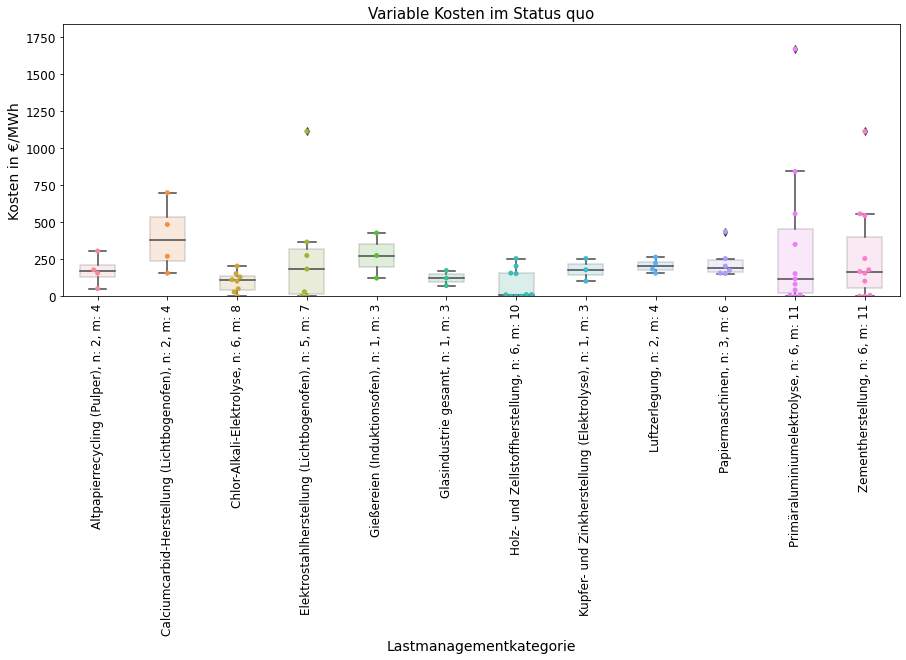

In [46]:
run_analyses_for_parameter_single_year(
    grouped, 
    swapped_cols_dict, 
    "variable Kosten",
    "ind",
    years_dict,
    "SQ",
    "Variable Kosten",
    "Kosten in €/MWh",
    plot_colors=colors,
    drop_data_lack=True,
    save_stats=True,
    path_folder_stats="./out/stats/",
    file_name_stats="stats.csv",
    save_sources=True,
    path_folder_sources="./out/sources/",
    file_name_sources="sources.csv",
    ylim=[0, 3000],
    use_colors=False,
    use_limits=True, 
    swarmplot=True,
    savefig=False,
    show_title=True,
    path_folder_plots="./out/plots/",
    file_name_plot="parameter",
    return_dfs=False
)

# Eligibility for load shifting / load shedding
* Extract eligibility for the status quo (cross-sectoral consideration)
* Groupby process categories
* Calculate the numbers for non-eligibility by calculating the differences between the overall amount and the numbers for eligibility
* Plot in a stacked bar plot
* Extract sources information

In [48]:
# Extrat info on eligibility and number off publications
grouped_SQ = grouped.loc[grouped["Jahr"].isin(status_quo_years)]
eligibility = grouped_SQ[
    ["Lastverschiebung", "Lastverzicht", "Lasterhöhung"]
].groupby(grouped_SQ.index).sum()
eligibility["Anzahl"] = grouped_SQ.index.value_counts()

# Calculate info on non-eligibility
eligibility["Lastverschiebung ungeeignet"] = (
    eligibility["Anzahl"].values - eligibility["Lastverschiebung"].values 
)
eligibility["Lastverzicht ungeeignet"] = (
    eligibility["Anzahl"].values - eligibility["Lastverzicht"].values 
)
eligibility["Lasterhöhung ungeeignet"] = (
    eligibility["Anzahl"].values - eligibility["Lasterhöhung"].values 
)
eligibility.sort_values(by="Anzahl", ascending=False, inplace=True)
eligibility.index.name = "Lastmanagementkategorie"

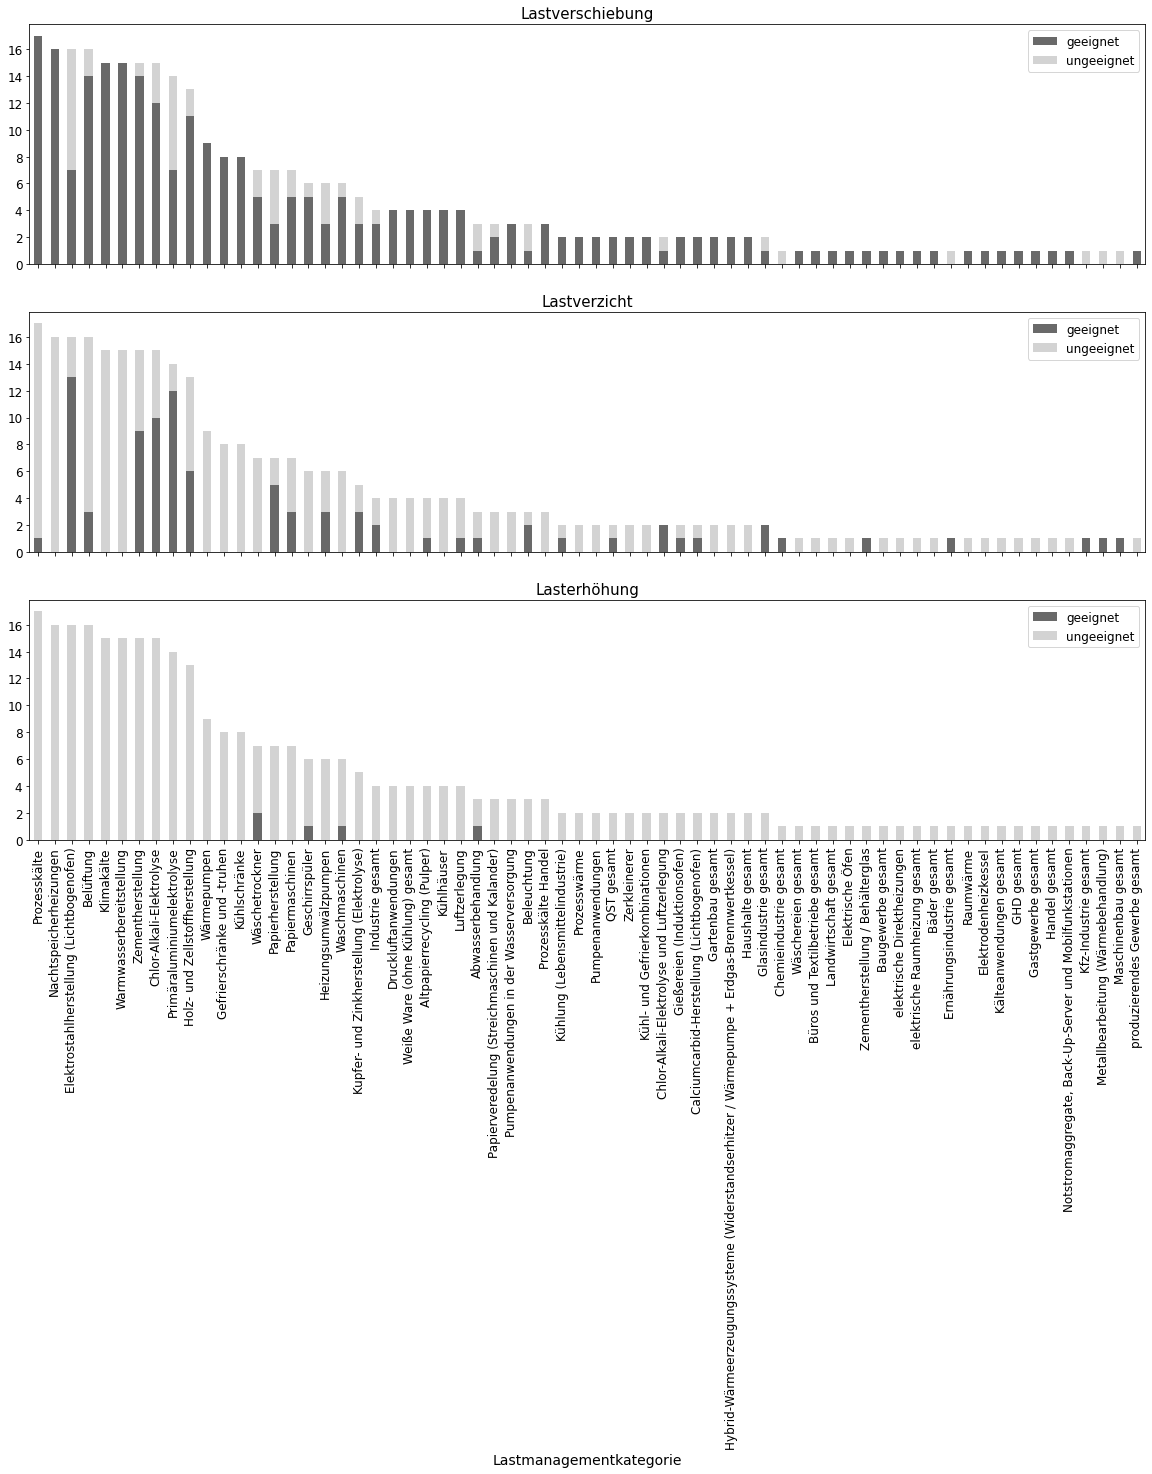

In [49]:
# Plot eligibiliy / non-eligibility information
fig, ax = plt.subplots(3, 1, figsize=(20,15), sharex = True)

for i, el in enumerate(["Lastverschiebung", "Lastverzicht", "Lasterhöhung"]):

    _ = eligibility[[el, el + " ungeeignet"]].rename(columns={
            el: "geeignet",
            el + " ungeeignet": "ungeeignet"
        }).plot(
            kind="bar", 
            stacked=True,
            color=["dimgrey", "lightgrey"],
            ax=ax[i]
    )
    _ = ax[i].set_title(el)

plt.savefig(path_folder_plots+"eligibility_all.png", dpi = 150, bbox_inches = "tight")

plt.show()    

In [72]:
# Extract sources infomation
sources_eligibility_df = grouped_SQ[[
    "Fundstelle Lastverzicht",
    "Fundstelle Lastverschiebung",
    "Fundstelle Lasterhöhung"
]].groupby(grouped_SQ.index).agg(lambda x: "; ".join(x))

eligibility_sources = extract_sample_sources(
    sources_eligibility_df, 
    save=True, 
    path_folder="./out/sources/", 
    file_name="sources_eligibility.txt"
)

# Capacity-related parameters
In the following, all capacity-related demand response parameters are evaluated. These comprise
* demand response potentials in positive or negative direction (in MW),
* average, minimum and maximum load factors (in percent of installed capacity) as well as
* installed capacities (in MW) and shiftable load share (in percent).

The evaluation is carried out per process / appliance / branch (demand response category) for a given sector and year.

## Industry

### Positive load shift potential

In [ ]:
extract_data_for_parameter_all_years(
    grouped, 
    swapped_cols_dict, 
    parameters="Potenzial positiv Mittel",
    sector="ind",
    years_dict=years_dict,
    file_name_stats="potential_pos_ave_ind_stats",
    file_name_sources="potential_pos_ave_ind_sources"
)

In [ ]:
run_analyses_for_parameter_single_year(
    grouped, 
    swapped_cols_dict, 
    parameters="Potenzial positiv Mittel",
    sector="ind",
    years_dict=years_dict,
    year="SQ",
    plot_title="Werte für das durchschnittliche positive Lastmanagementpotenzial (Lastreduktion)",
    plot_ylabel="durchschn. positives Potenzial in MW",
    plot_colors=colors
)

In [ ]:
extract_data_for_parameter_all_years(
    grouped, 
    swapped_cols_dict, 
    parameters="Potenzial positiv min",
    sector="ind",
    years_dict=years_dict,
    file_name_stats="potential_pos_min_ind_stats",
    file_name_sources="potential_pos_min_ind_sources"
)

In [ ]:
run_analyses_for_parameter_single_year(
    grouped, 
    swapped_cols_dict, 
    parameters="Potenzial positiv min",
    sector="ind",
    years_dict=years_dict,
    year="SQ",
    plot_title="Werte für das minimale positive Lastmanagementpotenzial (Lastreduktion)",
    plot_ylabel="minimales positives Potenzial in MW",
    plot_colors=colors
)

In [ ]:
extract_data_for_parameter_all_years(
    grouped, 
    swapped_cols_dict, 
    parameters="Potenzial positiv max",
    sector="ind",
    years_dict=years_dict,
    file_name_stats="potential_pos_max_ind_stats",
    file_name_sources="potential_pos_max_ind_sources",
)

In [ ]:
run_analyses_for_parameter_single_year(
    grouped, 
    swapped_cols_dict, 
    parameters="Potenzial positiv max",
    sector="ind",
    years_dict=years_dict,
    year="SQ",
    plot_title="Werte für das maximale positive Lastmanagementpotenzial (Lastreduktion)",
    plot_ylabel="maximales positives Potenzial in MW",
    plot_colors=colors
)

In [ ]:
extract_data_for_parameter_all_years(
    grouped, 
    swapped_cols_dict, 
    parameters=["Potenzial positiv Mittel", "Potenzial positiv min", "Potenzial positiv max"],
    sector="ind",
    years_dict=years_dict,
    file_name_stats="potential_pos_overall_ind_stats",
    file_name_sources="potential_pos_overall_ind_sources",
)

In [ ]:
run_analyses_for_parameter_single_year(
    grouped, 
    swapped_cols_dict, 
    parameters=["Potenzial positiv Mittel", "Potenzial positiv min", "Potenzial positiv max"],
    sector="ind",
    years_dict=years_dict,
    year="SQ",
    plot_title="Werte für das positive Lastmanagementpotenzial (Lastreduktion)",
    plot_ylabel="positives Potenzial in MW",
    plot_colors=colors,
)

### Positive load shedding potential

In [ ]:
extract_data_for_parameter_all_years(
    grouped, 
    swapped_cols_dict, 
    parameters="Potenzial positiv Mittel Lastverzicht",
    sector="ind",
    years_dict=years_dict,
    file_name_stats="potential_pos_ave_shed_ind_stats",
    file_name_sources="potential_pos_ave_shed_ind_sources",
)

In [ ]:
run_analyses_for_parameter_single_year(
    grouped, 
    swapped_cols_dict, 
    parameters="Potenzial positiv Mittel Lastverzicht",
    sector="ind",
    years_dict=years_dict,
    year="SQ",
    plot_title=(
        "Werte für das durchschnittliche positive "
        "Abschaltpotenzial (Lastverzicht)"
    ),
    plot_ylabel="durchschn. positives Potenzial in MW",
    plot_colors=colors,
)

In [ ]:
extract_data_for_parameter_all_years(
    grouped, 
    swapped_cols_dict, 
    parameters="Potenzial positiv min Lastverzicht",
    sector="ind",
    years_dict=years_dict,
    file_name_stats="potential_pos_min_shed_ind_stats",
    file_name_sources="potential_pos_min_shed_ind_sources",
)

In [ ]:
run_analyses_for_parameter_single_year(
    grouped, 
    swapped_cols_dict, 
    parameters="Potenzial positiv min Lastverzicht",
    sector="ind",
    years_dict=years_dict,
    year="SQ",
    plot_title="Werte für das minimale positive Abschaltpotenzial (Lastverzicht)",
    plot_ylabel="minimales positives Potenzial in MW",
    plot_colors=colors,
)

In [ ]:
extract_data_for_parameter_all_years(
    grouped, 
    swapped_cols_dict, 
    parameters="Potenzial positiv max Lastverzicht",
    sector="ind",
    years_dict=years_dict,
    file_name_stats="potential_pos_max_shed_ind_stats",
    file_name_sources="potential_pos_max_shed_ind_sources",
)

In [ ]:
run_analyses_for_parameter_single_year(
    grouped, 
    swapped_cols_dict, 
    parameters="Potenzial positiv max Lastverzicht",
    sector="ind",
    years_dict=years_dict,
    year="SQ",
    plot_title="Werte für das maximale positive Abschaltpotenzial (Lastverzicht)",
    plot_ylabel="maximales positives Potenzial in MW",
    plot_colors=colors,
)

In [ ]:
extract_data_for_parameter_all_years(
    grouped, 
    swapped_cols_dict, 
    parameters=[
        "Potenzial positiv Mittel Lastverzicht", 
        "Potenzial positiv min Lastverzicht", 
        "Potenzial positiv max Lastverzicht"
    ],
    sector="ind",
    years_dict=years_dict,
    file_name_stats="potential_pos_overall_shed_ind_stats",
    file_name_sources="potential_pos_overall_shed_ind_sources",
)

In [ ]:
run_analyses_for_parameter_single_year(
    grouped, 
    swapped_cols_dict, 
    parameters=[
        "Potenzial positiv Mittel Lastverzicht",
        "Potenzial positiv min Lastverzicht",
        "Potenzial positiv max Lastverzicht"],
    sector="ind",
    years_dict=years_dict,
    year="SQ",
    plot_title="Werte für das positive Abschaltpotenzial (Lastverzicht)",
    plot_ylabel="positives Potenzial in MW",
    plot_colors=colors,
)

### Negative load shift potential

In [ ]:
extract_data_for_parameter_all_years(
    grouped, 
    swapped_cols_dict, 
    parameters="Potenzial negativ Mittel",
    sector="ind",
    years_dict=years_dict,
    file_name_stats="potential_neg_ave_ind_stats",
    file_name_sources="potential_neg_ave_ind_sources",
)

In [ ]:
run_analyses_for_parameter_single_year(
    grouped, 
    swapped_cols_dict, 
    parameters="Potenzial negativ Mittel",
    sector="ind",
    years_dict=years_dict,
    year="SQ",
    plot_title=(
        "Werte für das durchschnittliche negative "
        "Lastmanagementpotenzial (Lasterhöhung)"
    ),
    plot_ylabel="durchschn. negatives Potenzial in MW",
    plot_colors=colors,
)

In [ ]:
extract_data_for_parameter_all_years(
    grouped, 
    swapped_cols_dict, 
    parameters="Potenzial negativ min",
    sector="ind",
    years_dict=years_dict,
    file_name_stats="potential_neg_min_ind_stats",
    file_name_sources="potential_neg_min_ind_sources",
)

In [ ]:
run_analyses_for_parameter_single_year(
    grouped, 
    swapped_cols_dict, 
    parameters="Potenzial negativ min",
    sector="ind",
    years_dict=years_dict,
    year="SQ",
    plot_title="Werte für das minimale negative Lastmanagementpotenzial (Lasterhöhung)",
    plot_ylabel="minimales negatives Potenzial in MW",
    plot_colors=colors,
)

In [ ]:
extract_data_for_parameter_all_years(
    grouped, 
    swapped_cols_dict, 
    parameters="Potenzial negativ max",
    sector="ind",
    years_dict=years_dict,
    file_name_stats="potential_neg_max_ind_stats",
    file_name_sources="potential_neg_max_ind_sources",
)

In [ ]:
run_analyses_for_parameter_single_year(
    grouped, 
    swapped_cols_dict, 
    parameters="Potenzial negativ max",
    sector="ind",
    years_dict=years_dict,
    year="SQ",
    plot_title="Werte für das maximale negative Lastmanagementpotenzial (Lasterhöhung)",
    plot_ylabel="maximales negatives Potenzial in MW",
    plot_colors=colors,
)

In [ ]:
extract_data_for_parameter_all_years(
    grouped, 
    swapped_cols_dict, 
    parameters=[
        "Potenzial negativ Mittel", 
        "Potenzial negativ min", 
        "Potenzial negativ max"
    ],
    sector="ind",
    years_dict=years_dict,
    file_name_stats="potential_neg_overall_ind_stats",
    file_name_sources="potential_neg_overall_ind_sources",
)

In [ ]:
run_analyses_for_parameter_single_year(
    grouped, 
    swapped_cols_dict, 
    parameters=[
        "Potenzial negativ Mittel", 
        "Potenzial negativ min", 
        "Potenzial negativ max"
    ],
    sector="ind",
    years_dict=years_dict,
    year="SQ",
    plot_title="Werte für das negative Lastmanagementpotenzial (Lastverhöhung)",
    plot_ylabel="negatives Potenzial in MW",
    plot_colors=colors,
)

### Average load values

In [ ]:
extract_data_for_parameter_all_years(
    grouped, 
    swapped_cols_dict, 
    parameters="Durchschnittsauslastung",
    sector="ind",
    years_dict=years_dict,
    file_name_stats="ave_load_ind_stats",
    file_name_sources="ave_load_ind_sources",
)

In [ ]:
run_analyses_for_parameter_single_year(
    grouped, 
    swapped_cols_dict, 
    parameters="Durchschnittsauslastung",
    sector="ind",
    years_dict=years_dict,
    year="SQ",
    plot_title="Durchschnittlicher Lastfaktor",
    plot_ylabel="Durchschnittlicher Lastfaktor in p.u.",
    plot_colors=colors,
)

### Minimum load values

In [ ]:
extract_data_for_parameter_all_years(
    grouped, 
    swapped_cols_dict, 
    parameters="Minimalauslastung",
    sector="ind",
    years_dict=years_dict,
    file_name_stats="min_load_ind_stats",
    file_name_sources="min_load_ind_sources",
)

In [ ]:
run_analyses_for_parameter_single_year(
    grouped, 
    swapped_cols_dict, 
    parameters="Minimalauslastung",
    sector="ind",
    years_dict=years_dict,
    year="SQ",
    plot_title="Minimaler Lastfaktor",
    plot_ylabel="Minimaler Lastfaktor in p.u.",
    plot_colors=colors,
)

### Maximum load values

In [ ]:
extract_data_for_parameter_all_years(
    grouped, 
    swapped_cols_dict, 
    parameters="Maximalauslastung",
    sector="ind",
    years_dict=years_dict,
    file_name_stats="max_load_ind_stats",
    file_name_sources="max_load_ind_sources",
)

In [ ]:
run_analyses_for_parameter_single_year(
    grouped, 
    swapped_cols_dict, 
    parameters="Maximalauslastung",
    sector="ind",
    years_dict=years_dict,
    year="SQ",
    plot_title="Maximaler Lastfaktor",
    plot_ylabel="Maximaler Lastfaktor in p.u.",
    plot_colors=colors,
)

### Installed capacity

In [ ]:
extract_data_for_parameter_all_years(
    grouped, 
    swapped_cols_dict, 
    parameters="installierte Leistung",
    sector="ind",
    years_dict=years_dict,
    file_name_stats="installed_cap_ind_stats",
    file_name_sources="installed_cap_ind_sources",
)

In [ ]:
run_analyses_for_parameter_single_year(
    grouped, 
    swapped_cols_dict, 
    parameters="installierte Leistung",
    sector="ind",
    years_dict=years_dict,
    year="SQ",
    plot_title="installierte Leistung",
    plot_ylabel="installierte Leistung in MW",
    plot_colors=colors,
)

### Shiftable share

In [ ]:
extract_data_for_parameter_all_years(
    grouped, 
    swapped_cols_dict, 
    parameters="flexibilisierbarer Leistungsanteil",
    sector="ind",
    years_dict=years_dict,
    file_name_stats="shiftable_share_ind_stats",
    file_name_sources="shiftable_share_ind_sources",
)

In [ ]:
run_analyses_for_parameter_single_year(
    grouped, 
    swapped_cols_dict, 
    parameters="flexibilisierbarer Leistungsanteil",
    sector="ind",
    years_dict=years_dict,
    year="SQ",
    plot_title="flexibilisierbarer Leistungsanteil",
    plot_ylabel="flexibilisierbarer Leistungsanteil in p.u.",
    plot_colors=colors,
)

## Trade, commerce and services

### Positive load shift potential

In [ ]:
extract_data_for_parameter_all_years(
    grouped, 
    swapped_cols_dict, 
    parameters="Potenzial positiv Mittel",
    sector="tcs",
    years_dict=years_dict,
    file_name_stats="potential_pos_ave_tcs_stats",
    file_name_sources="potential_pos_ave_tcs_sources"
)

In [ ]:
run_analyses_for_parameter_single_year(
    grouped, 
    swapped_cols_dict, 
    parameters="Potenzial positiv Mittel",
    sector="tcs",
    years_dict=years_dict,
    year="SQ",
    plot_title="Werte für das durchschnittliche positive Lastmanagementpotenzial (Lastreduktion)",
    plot_ylabel="durchschn. positives Potenzial in MW",
    plot_colors=colors
)

In [ ]:
extract_data_for_parameter_all_years(
    grouped, 
    swapped_cols_dict, 
    parameters="Potenzial positiv min",
    sector="tcs",
    years_dict=years_dict,
    file_name_stats="potential_pos_min_tcs_stats",
    file_name_sources="potential_pos_min_tcs_sources"
)

In [ ]:
run_analyses_for_parameter_single_year(
    grouped, 
    swapped_cols_dict, 
    parameters="Potenzial positiv min",
    sector="tcs",
    years_dict=years_dict,
    year="SQ",
    plot_title="Werte für das minimale positive Lastmanagementpotenzial (Lastreduktion)",
    plot_ylabel="minimales positives Potenzial in MW",
    plot_colors=colors
)

In [ ]:
extract_data_for_parameter_all_years(
    grouped, 
    swapped_cols_dict, 
    parameters="Potenzial positiv max",
    sector="tcs",
    years_dict=years_dict,
    file_name_stats="potential_pos_max_tcs_stats",
    file_name_sources="potential_pos_max_tcs_sources",
)

In [ ]:
run_analyses_for_parameter_single_year(
    grouped, 
    swapped_cols_dict, 
    parameters="Potenzial positiv max",
    sector="tcs",
    years_dict=years_dict,
    year="SQ",
    plot_title="Werte für das maximale positive Lastmanagementpotenzial (Lastreduktion)",
    plot_ylabel="maximales positives Potenzial in MW",
    plot_colors=colors
)

In [ ]:
extract_data_for_parameter_all_years(
    grouped, 
    swapped_cols_dict, 
    parameters=["Potenzial positiv Mittel", "Potenzial positiv min", "Potenzial positiv max"],
    sector="tcs",
    years_dict=years_dict,
    file_name_stats="potential_pos_overall_tcs_stats",
    file_name_sources="potential_pos_overall_tcs_sources",
)

In [ ]:
run_analyses_for_parameter_single_year(
    grouped, 
    swapped_cols_dict, 
    parameters=["Potenzial positiv Mittel", "Potenzial positiv min", "Potenzial positiv max"],
    sector="tcs",
    years_dict=years_dict,
    year="SQ",
    plot_title="Werte für das positive Lastmanagementpotenzial (Lastreduktion)",
    plot_ylabel="positives Potenzial in MW",
    plot_colors=colors,
)

### Positive load shedding potential

In [ ]:
extract_data_for_parameter_all_years(
    grouped, 
    swapped_cols_dict, 
    parameters="Potenzial positiv Mittel Lastverzicht",
    sector="tcs",
    years_dict=years_dict,
    file_name_stats="potential_pos_ave_shed_tcs_stats",
    file_name_sources="potential_pos_ave_shed_tcs_sources",
)

In [ ]:
run_analyses_for_parameter_single_year(
    grouped, 
    swapped_cols_dict, 
    parameters="Potenzial positiv Mittel Lastverzicht",
    sector="tcs",
    years_dict=years_dict,
    year="SQ",
    plot_title=(
        "Werte für das durchschnittliche positive "
        "Abschaltpotenzial (Lastverzicht)"
    ),
    plot_ylabel="durchschn. positives Potenzial in MW",
    plot_colors=colors,
)

In [ ]:
extract_data_for_parameter_all_years(
    grouped, 
    swapped_cols_dict, 
    parameters="Potenzial positiv min Lastverzicht",
    sector="tcs",
    years_dict=years_dict,
    file_name_stats="potential_pos_min_shed_tcs_stats",
    file_name_sources="potential_pos_min_shed_tcs_sources",
)

In [ ]:
run_analyses_for_parameter_single_year(
    grouped, 
    swapped_cols_dict, 
    parameters="Potenzial positiv min Lastverzicht",
    sector="tcs",
    years_dict=years_dict,
    year="SQ",
    plot_title="Werte für das minimale positive Abschaltpotenzial (Lastverzicht)",
    plot_ylabel="minimales positives Potenzial in MW",
    plot_colors=colors,
)

In [ ]:
extract_data_for_parameter_all_years(
    grouped, 
    swapped_cols_dict, 
    parameters="Potenzial positiv max Lastverzicht",
    sector="tcs",
    years_dict=years_dict,
    file_name_stats="potential_pos_max_shed_tcs_stats",
    file_name_sources="potential_pos_max_shed_tcs_sources",
)

In [ ]:
run_analyses_for_parameter_single_year(
    grouped, 
    swapped_cols_dict, 
    parameters="Potenzial positiv max Lastverzicht",
    sector="tcs",
    years_dict=years_dict,
    year="SQ",
    plot_title="Werte für das maximale positive Abschaltpotenzial (Lastverzicht)",
    plot_ylabel="maximales positives Potenzial in MW",
    plot_colors=colors,
)

In [ ]:
extract_data_for_parameter_all_years(
    grouped, 
    swapped_cols_dict, 
    parameters=[
        "Potenzial positiv Mittel Lastverzicht", 
        "Potenzial positiv min Lastverzicht", 
        "Potenzial positiv max Lastverzicht"
    ],
    sector="tcs",
    years_dict=years_dict,
    file_name_stats="potential_pos_overall_shed_tcs_stats",
    file_name_sources="potential_pos_overall_shed_tcs_sources",
)

In [ ]:
run_analyses_for_parameter_single_year(
    grouped, 
    swapped_cols_dict, 
    parameters=[
        "Potenzial positiv Mittel Lastverzicht",
        "Potenzial positiv min Lastverzicht",
        "Potenzial positiv max Lastverzicht"],
    sector="tcs",
    years_dict=years_dict,
    year="SQ",
    plot_title="Werte für das positive Abschaltpotenzial (Lastverzicht)",
    plot_ylabel="positives Potenzial in MW",
    plot_colors=colors,
)

### Negative load shift potential

In [ ]:
extract_data_for_parameter_all_years(
    grouped, 
    swapped_cols_dict, 
    parameters="Potenzial negativ Mittel",
    sector="tcs",
    years_dict=years_dict,
    file_name_stats="potential_neg_ave_tcs_stats",
    file_name_sources="potential_neg_ave_tcs_sources",
)

In [ ]:
run_analyses_for_parameter_single_year(
    grouped, 
    swapped_cols_dict, 
    parameters="Potenzial negativ Mittel",
    sector="tcs",
    years_dict=years_dict,
    year="SQ",
    plot_title=(
        "Werte für das durchschnittliche negative "
        "Lastmanagementpotenzial (Lasterhöhung)"
    ),
    plot_ylabel="durchschn. negatives Potenzial in MW",
    plot_colors=colors,
)

In [ ]:
extract_data_for_parameter_all_years(
    grouped, 
    swapped_cols_dict, 
    parameters="Potenzial negativ min",
    sector="tcs",
    years_dict=years_dict,
    file_name_stats="potential_neg_min_tcs_stats",
    file_name_sources="potential_neg_min_tcs_sources",
)

In [ ]:
run_analyses_for_parameter_single_year(
    grouped, 
    swapped_cols_dict, 
    parameters="Potenzial negativ min",
    sector="tcs",
    years_dict=years_dict,
    year="SQ",
    plot_title="Werte für das minimale negative Lastmanagementpotenzial (Lasterhöhung)",
    plot_ylabel="minimales negatives Potenzial in MW",
    plot_colors=colors,
)

In [ ]:
extract_data_for_parameter_all_years(
    grouped, 
    swapped_cols_dict, 
    parameters="Potenzial negativ max",
    sector="tcs",
    years_dict=years_dict,
    file_name_stats="potential_neg_max_tcs_stats",
    file_name_sources="potential_neg_max_tcs_sources",
)

In [ ]:
run_analyses_for_parameter_single_year(
    grouped, 
    swapped_cols_dict, 
    parameters="Potenzial negativ max",
    sector="tcs",
    years_dict=years_dict,
    year="SQ",
    plot_title="Werte für das maximale negative Lastmanagementpotenzial (Lasterhöhung)",
    plot_ylabel="maximales negatives Potenzial in MW",
    plot_colors=colors,
)

In [ ]:
extract_data_for_parameter_all_years(
    grouped, 
    swapped_cols_dict, 
    parameters=[
        "Potenzial negativ Mittel", 
        "Potenzial negativ min", 
        "Potenzial negativ max"
    ],
    sector="tcs",
    years_dict=years_dict,
    file_name_stats="potential_neg_overall_tcs_stats",
    file_name_sources="potential_neg_overall_tcs_sources",
)

In [ ]:
run_analyses_for_parameter_single_year(
    grouped, 
    swapped_cols_dict, 
    parameters=[
        "Potenzial negativ Mittel", 
        "Potenzial negativ min", 
        "Potenzial negativ max"
    ],
    sector="tcs",
    years_dict=years_dict,
    year="SQ",
    plot_title="Werte für das negative Lastmanagementpotenzial (Lastverhöhung)",
    plot_ylabel="negatives Potenzial in MW",
    plot_colors=colors,
)

### Average load values

In [ ]:
extract_data_for_parameter_all_years(
    grouped, 
    swapped_cols_dict, 
    parameters="Durchschnittsauslastung",
    sector="tcs",
    years_dict=years_dict,
    file_name_stats="ave_load_tcs_stats",
    file_name_sources="ave_load_tcs_sources",
)

In [ ]:
run_analyses_for_parameter_single_year(
    grouped, 
    swapped_cols_dict, 
    parameters="Durchschnittsauslastung",
    sector="tcs",
    years_dict=years_dict,
    year="SQ",
    plot_title="Durchschnittlicher Lastfaktor",
    plot_ylabel="Durchschnittlicher Lastfaktor in p.u.",
    plot_colors=colors,
)

### Minimum load values

In [ ]:
extract_data_for_parameter_all_years(
    grouped, 
    swapped_cols_dict, 
    parameters="Minimalauslastung",
    sector="tcs",
    years_dict=years_dict,
    file_name_stats="min_load_tcs_stats",
    file_name_sources="min_load_tcs_sources",
)

In [ ]:
run_analyses_for_parameter_single_year(
    grouped, 
    swapped_cols_dict, 
    parameters="Minimalauslastung",
    sector="tcs",
    years_dict=years_dict,
    year="SQ",
    plot_title="Minimaler Lastfaktor",
    plot_ylabel="Minimaler Lastfaktor in p.u.",
    plot_colors=colors,
)

### Maximum load values

In [ ]:
extract_data_for_parameter_all_years(
    grouped, 
    swapped_cols_dict, 
    parameters="Maximalauslastung",
    sector="tcs",
    years_dict=years_dict,
    file_name_stats="max_load_tcs_stats",
    file_name_sources="max_load_tcs_sources",
)

In [ ]:
run_analyses_for_parameter_single_year(
    grouped, 
    swapped_cols_dict, 
    parameters="Maximalauslastung",
    sector="tcs",
    years_dict=years_dict,
    year="SQ",
    plot_title="Maximaler Lastfaktor",
    plot_ylabel="Maximaler Lastfaktor in p.u.",
    plot_colors=colors,
)

### Installed capacity

In [ ]:
extract_data_for_parameter_all_years(
    grouped, 
    swapped_cols_dict, 
    parameters="installierte Leistung",
    sector="tcs",
    years_dict=years_dict,
    file_name_stats="installed_cap_tcs_stats",
    file_name_sources="installed_cap_tcs_sources",
)

In [ ]:
run_analyses_for_parameter_single_year(
    grouped, 
    swapped_cols_dict, 
    parameters="installierte Leistung",
    sector="tcs",
    years_dict=years_dict,
    year="SQ",
    plot_title="installierte Leistung",
    plot_ylabel="installierte Leistung in MW",
    plot_colors=colors,
)

### Shiftable share

In [ ]:
extract_data_for_parameter_all_years(
    grouped, 
    swapped_cols_dict, 
    parameters="flexibilisierbarer Leistungsanteil",
    sector="tcs",
    years_dict=years_dict,
    file_name_stats="shiftable_share_tcs_stats",
    file_name_sources="shiftable_share_tcs_sources",
)

In [ ]:
run_analyses_for_parameter_single_year(
    grouped, 
    swapped_cols_dict, 
    parameters="flexibilisierbarer Leistungsanteil",
    sector="tcs",
    years_dict=years_dict,
    year="SQ",
    plot_title="flexibilisierbarer Leistungsanteil",
    plot_ylabel="flexibilisierbarer Leistungsanteil in p.u.",
    plot_colors=colors,
)

## Households

### Positive load shift potential

In [ ]:
extract_data_for_parameter_all_years(
    grouped, 
    swapped_cols_dict, 
    parameters="Potenzial positiv Mittel",
    sector="hoho",
    years_dict=years_dict,
    file_name_stats="potential_pos_ave_hoho_stats",
    file_name_sources="potential_pos_ave_hoho_sources"
)

In [ ]:
run_analyses_for_parameter_single_year(
    grouped, 
    swapped_cols_dict, 
    parameters="Potenzial positiv Mittel",
    sector="hoho",
    years_dict=years_dict,
    year="SQ",
    plot_title="Werte für das durchschnittliche positive Lastmanagementpotenzial (Lastreduktion)",
    plot_ylabel="durchschn. positives Potenzial in MW",
    plot_colors=colors
)

In [ ]:
extract_data_for_parameter_all_years(
    grouped, 
    swapped_cols_dict, 
    parameters="Potenzial positiv min",
    sector="hoho",
    years_dict=years_dict,
    file_name_stats="potential_pos_min_hoho_stats",
    file_name_sources="potential_pos_min_hoho_sources"
)

In [ ]:
run_analyses_for_parameter_single_year(
    grouped, 
    swapped_cols_dict, 
    parameters="Potenzial positiv min",
    sector="hoho",
    years_dict=years_dict,
    year="SQ",
    plot_title="Werte für das minimale positive Lastmanagementpotenzial (Lastreduktion)",
    plot_ylabel="minimales positives Potenzial in MW",
    plot_colors=colors
)

In [ ]:
extract_data_for_parameter_all_years(
    grouped, 
    swapped_cols_dict, 
    parameters="Potenzial positiv max",
    sector="hoho",
    years_dict=years_dict,
    file_name_stats="potential_pos_max_hoho_stats",
    file_name_sources="potential_pos_max_hoho_sources",
)

In [ ]:
run_analyses_for_parameter_single_year(
    grouped, 
    swapped_cols_dict, 
    parameters="Potenzial positiv max",
    sector="hoho",
    years_dict=years_dict,
    year="SQ",
    plot_title="Werte für das maximale positive Lastmanagementpotenzial (Lastreduktion)",
    plot_ylabel="maximales positives Potenzial in MW",
    plot_colors=colors
)

In [ ]:
extract_data_for_parameter_all_years(
    grouped, 
    swapped_cols_dict, 
    parameters=["Potenzial positiv Mittel", "Potenzial positiv min", "Potenzial positiv max"],
    sector="hoho",
    years_dict=years_dict,
    file_name_stats="potential_pos_overall_hoho_stats",
    file_name_sources="potential_pos_overall_hoho_sources",
)

In [ ]:
run_analyses_for_parameter_single_year(
    grouped, 
    swapped_cols_dict, 
    parameters=["Potenzial positiv Mittel", "Potenzial positiv min", "Potenzial positiv max"],
    sector="hoho",
    years_dict=years_dict,
    year="SQ",
    plot_title="Werte für das positive Lastmanagementpotenzial (Lastreduktion)",
    plot_ylabel="positives Potenzial in MW",
    plot_colors=colors,
)

### Positive load shedding potential

In [ ]:
extract_data_for_parameter_all_years(
    grouped, 
    swapped_cols_dict, 
    parameters="Potenzial positiv Mittel Lastverzicht",
    sector="hoho",
    years_dict=years_dict,
    file_name_stats="potential_pos_ave_shed_hoho_stats",
    file_name_sources="potential_pos_ave_shed_hoho_sources",
)

In [ ]:
run_analyses_for_parameter_single_year(
    grouped, 
    swapped_cols_dict, 
    parameters="Potenzial positiv Mittel Lastverzicht",
    sector="hoho",
    years_dict=years_dict,
    year="SQ",
    plot_title=(
        "Werte für das durchschnittliche positive "
        "Abschaltpotenzial (Lastverzicht)"
    ),
    plot_ylabel="durchschn. positives Potenzial in MW",
    plot_colors=colors,
)

In [ ]:
extract_data_for_parameter_all_years(
    grouped, 
    swapped_cols_dict, 
    parameters="Potenzial positiv min Lastverzicht",
    sector="hoho",
    years_dict=years_dict,
    file_name_stats="potential_pos_min_shed_hoho_stats",
    file_name_sources="potential_pos_min_shed_hoho_sources",
)

In [ ]:
run_analyses_for_parameter_single_year(
    grouped, 
    swapped_cols_dict, 
    parameters="Potenzial positiv min Lastverzicht",
    sector="hoho",
    years_dict=years_dict,
    year="SQ",
    plot_title="Werte für das minimale positive Abschaltpotenzial (Lastverzicht)",
    plot_ylabel="minimales positives Potenzial in MW",
    plot_colors=colors,
)

In [ ]:
extract_data_for_parameter_all_years(
    grouped, 
    swapped_cols_dict, 
    parameters="Potenzial positiv max Lastverzicht",
    sector="hoho",
    years_dict=years_dict,
    file_name_stats="potential_pos_max_shed_hoho_stats",
    file_name_sources="potential_pos_max_shed_hoho_sources",
)

In [ ]:
run_analyses_for_parameter_single_year(
    grouped, 
    swapped_cols_dict, 
    parameters="Potenzial positiv max Lastverzicht",
    sector="hoho",
    years_dict=years_dict,
    year="SQ",
    plot_title="Werte für das maximale positive Abschaltpotenzial (Lastverzicht)",
    plot_ylabel="maximales positives Potenzial in MW",
    plot_colors=colors,
)

In [ ]:
extract_data_for_parameter_all_years(
    grouped, 
    swapped_cols_dict, 
    parameters=[
        "Potenzial positiv Mittel Lastverzicht", 
        "Potenzial positiv min Lastverzicht", 
        "Potenzial positiv max Lastverzicht"
    ],
    sector="hoho",
    years_dict=years_dict,
    file_name_stats="potential_pos_overall_shed_hoho_stats",
    file_name_sources="potential_pos_overall_shed_hoho_sources",
)

In [ ]:
run_analyses_for_parameter_single_year(
    grouped, 
    swapped_cols_dict, 
    parameters=[
        "Potenzial positiv Mittel Lastverzicht",
        "Potenzial positiv min Lastverzicht",
        "Potenzial positiv max Lastverzicht"],
    sector="hoho",
    years_dict=years_dict,
    year="SQ",
    plot_title="Werte für das positive Abschaltpotenzial (Lastverzicht)",
    plot_ylabel="positives Potenzial in MW",
    plot_colors=colors,
)

### Negative load shift potential

In [ ]:
extract_data_for_parameter_all_years(
    grouped, 
    swapped_cols_dict, 
    parameters="Potenzial negativ Mittel",
    sector="hoho",
    years_dict=years_dict,
    file_name_stats="potential_neg_ave_hoho_stats",
    file_name_sources="potential_neg_ave_hoho_sources",
)

In [ ]:
run_analyses_for_parameter_single_year(
    grouped, 
    swapped_cols_dict, 
    parameters="Potenzial negativ Mittel",
    sector="hoho",
    years_dict=years_dict,
    year="SQ",
    plot_title=(
        "Werte für das durchschnittliche negative "
        "Lastmanagementpotenzial (Lasterhöhung)"
    ),
    plot_ylabel="durchschn. negatives Potenzial in MW",
    plot_colors=colors,
)

In [ ]:
extract_data_for_parameter_all_years(
    grouped, 
    swapped_cols_dict, 
    parameters="Potenzial negativ min",
    sector="hoho",
    years_dict=years_dict,
    file_name_stats="potential_neg_min_hoho_stats",
    file_name_sources="potential_neg_min_hoho_sources",
)

In [ ]:
run_analyses_for_parameter_single_year(
    grouped, 
    swapped_cols_dict, 
    parameters="Potenzial negativ min",
    sector="hoho",
    years_dict=years_dict,
    year="SQ",
    plot_title="Werte für das minimale negative Lastmanagementpotenzial (Lasterhöhung)",
    plot_ylabel="minimales negatives Potenzial in MW",
    plot_colors=colors,
)

In [ ]:
extract_data_for_parameter_all_years(
    grouped, 
    swapped_cols_dict, 
    parameters="Potenzial negativ max",
    sector="hoho",
    years_dict=years_dict,
    file_name_stats="potential_neg_max_hoho_stats",
    file_name_sources="potential_neg_max_hoho_sources",
)

In [ ]:
run_analyses_for_parameter_single_year(
    grouped, 
    swapped_cols_dict, 
    parameters="Potenzial negativ max",
    sector="hoho",
    years_dict=years_dict,
    year="SQ",
    plot_title="Werte für das maximale negative Lastmanagementpotenzial (Lasterhöhung)",
    plot_ylabel="maximales negatives Potenzial in MW",
    plot_colors=colors,
)

In [ ]:
extract_data_for_parameter_all_years(
    grouped, 
    swapped_cols_dict, 
    parameters=[
        "Potenzial negativ Mittel", 
        "Potenzial negativ min", 
        "Potenzial negativ max"
    ],
    sector="hoho",
    years_dict=years_dict,
    file_name_stats="potential_neg_overall_hoho_stats",
    file_name_sources="potential_neg_overall_hoho_sources",
)

In [ ]:
run_analyses_for_parameter_single_year(
    grouped, 
    swapped_cols_dict, 
    parameters=[
        "Potenzial negativ Mittel", 
        "Potenzial negativ min", 
        "Potenzial negativ max"
    ],
    sector="hoho",
    years_dict=years_dict,
    year="SQ",
    plot_title="Werte für das negative Lastmanagementpotenzial (Lastverhöhung)",
    plot_ylabel="negatives Potenzial in MW",
    plot_colors=colors,
)

### Average load values

In [ ]:
extract_data_for_parameter_all_years(
    grouped, 
    swapped_cols_dict, 
    parameters="Durchschnittsauslastung",
    sector="hoho",
    years_dict=years_dict,
    file_name_stats="ave_load_hoho_stats",
    file_name_sources="ave_load_hoho_sources",
)

In [ ]:
run_analyses_for_parameter_single_year(
    grouped, 
    swapped_cols_dict, 
    parameters="Durchschnittsauslastung",
    sector="hoho",
    years_dict=years_dict,
    year="SQ",
    plot_title="Durchschnittlicher Lastfaktor",
    plot_ylabel="Durchschnittlicher Lastfaktor in p.u.",
    plot_colors=colors,
)

### Minimum load values

In [ ]:
extract_data_for_parameter_all_years(
    grouped, 
    swapped_cols_dict, 
    parameters="Minimalauslastung",
    sector="hoho",
    years_dict=years_dict,
    file_name_stats="min_load_hoho_stats",
    file_name_sources="min_load_hoho_sources",
)

In [ ]:
run_analyses_for_parameter_single_year(
    grouped, 
    swapped_cols_dict, 
    parameters="Minimalauslastung",
    sector="hoho",
    years_dict=years_dict,
    year="SQ",
    plot_title="Minimaler Lastfaktor",
    plot_ylabel="Minimaler Lastfaktor in p.u.",
    plot_colors=colors,
)

### Maximum load values

In [ ]:
extract_data_for_parameter_all_years(
    grouped, 
    swapped_cols_dict, 
    parameters="Maximalauslastung",
    sector="hoho",
    years_dict=years_dict,
    file_name_stats="max_load_hoho_stats",
    file_name_sources="max_load_hoho_sources",
)

In [ ]:
run_analyses_for_parameter_single_year(
    grouped, 
    swapped_cols_dict, 
    parameters="Maximalauslastung",
    sector="hoho",
    years_dict=years_dict,
    year="SQ",
    plot_title="Maximaler Lastfaktor",
    plot_ylabel="Maximaler Lastfaktor in p.u.",
    plot_colors=colors,
)

### Installed capacity

In [ ]:
extract_data_for_parameter_all_years(
    grouped, 
    swapped_cols_dict, 
    parameters="installierte Leistung",
    sector="hoho",
    years_dict=years_dict,
    file_name_stats="installed_cap_hoho_stats",
    file_name_sources="installed_cap_hoho_sources",
)

In [ ]:
run_analyses_for_parameter_single_year(
    grouped, 
    swapped_cols_dict, 
    parameters="installierte Leistung",
    sector="hoho",
    years_dict=years_dict,
    year="SQ",
    plot_title="installierte Leistung",
    plot_ylabel="installierte Leistung in MW",
    plot_colors=colors,
)

### Shiftable share

In [ ]:
extract_data_for_parameter_all_years(
    grouped, 
    swapped_cols_dict, 
    parameters="flexibilisierbarer Leistungsanteil",
    sector="hoho",
    years_dict=years_dict,
    file_name_stats="shiftable_share_hoho_stats",
    file_name_sources="shiftable_share_hoho_sources",
)

In [ ]:
run_analyses_for_parameter_single_year(
    grouped, 
    swapped_cols_dict, 
    parameters="flexibilisierbarer Leistungsanteil",
    sector="hoho",
    years_dict=years_dict,
    year="SQ",
    plot_title="flexibilisierbarer Leistungsanteil",
    plot_ylabel="flexibilisierbarer Leistungsanteil in p.u.",
    plot_colors=colors,
)

# Time-related parameters
In the following, all time-related demand response parameters are evaluated. These comprise
* activation duration (in h),
* interference duration in postive (shifting and shedding) and negative direction (in h),
* shifting duration (in h),
* regeneration duration (in h) as well as
* maximum activations per year (for shifting and shedding) (in 1).

The evaluation is carried out per process / appliance for a given sector and year.

## Industry

### Activation duration

In [ ]:
extract_data_for_parameter_all_years(
    grouped, 
    swapped_cols_dict, 
    parameters="Aktivierungsdauer",
    sector="ind",
    years_dict=years_dict,
    file_name_stats="activation_duration_ind_stats",
    file_name_sources="activation_duration_ind_sources"
)

In [ ]:
run_analyses_for_parameter_single_year(
    grouped, 
    swapped_cols_dict, 
    parameters="Aktivierungsdauer",
    sector="ind",
    years_dict=years_dict,
    year="SQ",
    plot_title="Aktivierungsdauer",
    plot_ylabel="Aktivierungsdauer in h",
    plot_colors=colors
)

### interference duration positive load shifting

In [ ]:
extract_data_for_parameter_all_years(
    grouped, 
    swapped_cols_dict, 
    parameters="Schaltdauer positiv",
    sector="ind",
    years_dict=years_dict,
    file_name_stats="interference_duration_pos_ind_stats",
    file_name_sources="interference_duration_pos_ind_sources"
)

In [ ]:
run_analyses_for_parameter_single_year(
    grouped, 
    swapped_cols_dict, 
    parameters="Schaltdauer positiv",
    sector="ind",
    years_dict=years_dict,
    year="SQ",
    plot_title="positive Schaltdauer (Lastreduktion)",
    plot_ylabel="positive Schaltdauer in h",
    plot_colors=colors
)

### interference duration positive load shedding

In [ ]:
extract_data_for_parameter_all_years(
    grouped, 
    swapped_cols_dict, 
    parameters="Schaltdauer positiv Lastverzicht",
    sector="ind",
    years_dict=years_dict,
    file_name_stats="interference_duration_pos_shed_ind_stats",
    file_name_sources="interference_duration_pos_shed_ind_sources"
)

In [ ]:
run_analyses_for_parameter_single_year(
    grouped, 
    swapped_cols_dict, 
    parameters="Schaltdauer positiv Lastverzicht",
    sector="ind",
    years_dict=years_dict,
    year="SQ",
    plot_title="positive Schaltdauer (Lastverzicht)",
    plot_ylabel="positive Schaltdauer in h",
    plot_colors=colors
)

### interference duration negative

In [ ]:
extract_data_for_parameter_all_years(
    grouped, 
    swapped_cols_dict, 
    parameters="Schaltdauer negativ",
    sector="ind",
    years_dict=years_dict,
    file_name_stats="interference_duration_neg_ind_stats",
    file_name_sources="interference_duration_neg_ind_sources"
)

In [ ]:
run_analyses_for_parameter_single_year(
    grouped, 
    swapped_cols_dict, 
    parameters="Schaltdauer negativ",
    sector="ind",
    years_dict=years_dict,
    year="SQ",
    plot_title="negative Schaltdauer (Lasterhöhung)",
    plot_ylabel="negative Schaltdauer in h",
    plot_colors=colors
)

### shifting duration

In [ ]:
extract_data_for_parameter_all_years(
    grouped, 
    swapped_cols_dict, 
    parameters="Verschiebedauer",
    sector="ind",
    years_dict=years_dict,
    file_name_stats="shifting_duration_ind_stats",
    file_name_sources="shifting_duration_ind_sources"
)

In [ ]:
run_analyses_for_parameter_single_year(
    grouped, 
    swapped_cols_dict, 
    parameters="Verschiebedauer",
    sector="ind",
    years_dict=years_dict,
    year="SQ",
    plot_title="Verschiebedauer",
    plot_ylabel="Verschiebedauer in h",
    plot_colors=colors
)

### regeneration duration

In [ ]:
extract_data_for_parameter_all_years(
    grouped, 
    swapped_cols_dict, 
    parameters="Regenerationsdauer",
    sector="ind",
    years_dict=years_dict,
    file_name_stats="regeneration_duration_ind_stats",
    file_name_sources="regeneration_duration_ind_sources"
)

In [ ]:
run_analyses_for_parameter_single_year(
    grouped, 
    swapped_cols_dict, 
    parameters="Regenerationsdauer",
    sector="ind",
    years_dict=years_dict,
    year="SQ",
    plot_title="Regenerationsdauer",
    plot_ylabel="Regenerationsdauer in h",
    plot_colors=colors
)

### maximum activations per year load shifting

In [ ]:
extract_data_for_parameter_all_years(
    grouped, 
    swapped_cols_dict, 
    parameters="maximale Abrufhäufigkeit pro Jahr",
    sector="ind",
    years_dict=years_dict,
    file_name_stats="maximum_activations_year_ind_stats",
    file_name_sources="maximum_activations_year_ind_sources"
)

In [ ]:
run_analyses_for_parameter_single_year(
    grouped, 
    swapped_cols_dict, 
    parameters="maximale Abrufhäufigkeit pro Jahr",
    sector="ind",
    years_dict=years_dict,
    year="SQ",
    plot_title="Maximale Aktivierungshäufigkeit pro Jahr",
    plot_ylabel="Anzahl an Aktivierungen in 1/a",
    plot_colors=colors
)

### maximum activations per year load shedding

In [ ]:
extract_data_for_parameter_all_years(
    grouped, 
    swapped_cols_dict, 
    parameters="maximale Abrufhäufigkeit pro Jahr Lastverzicht",
    sector="ind",
    years_dict=years_dict,
    file_name_stats="maximum_activations_year_shed_ind_stats",
    file_name_sources="maximum_activations_year_shed_ind_sources"
)

In [ ]:
run_analyses_for_parameter_single_year(
    grouped, 
    swapped_cols_dict, 
    parameters="maximale Abrufhäufigkeit pro Jahr Lastverzicht",
    sector="ind",
    years_dict=years_dict,
    year="SQ",
    plot_title="Maximale Aktivierungshäufigkeit pro Jahr (Lastverzicht)",
    plot_ylabel="Anzahl an Aktivierungen in 1/a",
    plot_colors=colors
)

## Trade, commerce and services

### Activation duration

In [ ]:
extract_data_for_parameter_all_years(
    grouped, 
    swapped_cols_dict, 
    parameters="Aktivierungsdauer",
    sector="tcs",
    years_dict=years_dict,
    file_name_stats="activation_duration_tcs_stats",
    file_name_sources="activation_duration_tcs_sources"
)

In [ ]:
run_analyses_for_parameter_single_year(
    grouped, 
    swapped_cols_dict, 
    parameters="Aktivierungsdauer",
    sector="tcs",
    years_dict=years_dict,
    year="SQ",
    plot_title="Aktivierungsdauer",
    plot_ylabel="Aktivierungsdauer in h",
    plot_colors=colors
)

### interference duration positive load shifting

In [ ]:
extract_data_for_parameter_all_years(
    grouped, 
    swapped_cols_dict, 
    parameters="Schaltdauer positiv",
    sector="tcs",
    years_dict=years_dict,
    file_name_stats="interference_duration_pos_tcs_stats",
    file_name_sources="interference_duration_pos_tcs_sources"
)

In [ ]:
run_analyses_for_parameter_single_year(
    grouped, 
    swapped_cols_dict, 
    parameters="Schaltdauer positiv",
    sector="tcs",
    years_dict=years_dict,
    year="SQ",
    plot_title="positive Schaltdauer (Lastreduktion)",
    plot_ylabel="positive Schaltdauer in h",
    plot_colors=colors
)

### interference duration positive load shedding

In [ ]:
extract_data_for_parameter_all_years(
    grouped, 
    swapped_cols_dict, 
    parameters="Schaltdauer positiv Lastverzicht",
    sector="tcs",
    years_dict=years_dict,
    file_name_stats="interference_duration_pos_shed_tcs_stats",
    file_name_sources="interference_duration_pos_shed_tcs_sources"
)

In [ ]:
run_analyses_for_parameter_single_year(
    grouped, 
    swapped_cols_dict, 
    parameters="Schaltdauer positiv Lastverzicht",
    sector="tcs",
    years_dict=years_dict,
    year="SQ",
    plot_title="positive Schaltdauer (Lastverzicht)",
    plot_ylabel="positive Schaltdauer in h",
    plot_colors=colors
)

### interference duration negative

In [ ]:
extract_data_for_parameter_all_years(
    grouped, 
    swapped_cols_dict, 
    parameters="Schaltdauer negativ",
    sector="tcs",
    years_dict=years_dict,
    file_name_stats="interference_duration_neg_tcs_stats",
    file_name_sources="interference_duration_neg_tcs_sources"
)

In [ ]:
run_analyses_for_parameter_single_year(
    grouped, 
    swapped_cols_dict, 
    parameters="Schaltdauer negativ",
    sector="tcs",
    years_dict=years_dict,
    year="SQ",
    plot_title="negative Schaltdauer (Lasterhöhung)",
    plot_ylabel="negative Schaltdauer in h",
    plot_colors=colors
)

### shifting duration

In [ ]:
extract_data_for_parameter_all_years(
    grouped, 
    swapped_cols_dict, 
    parameters="Verschiebedauer",
    sector="tcs",
    years_dict=years_dict,
    file_name_stats="shifting_duration_tcs_stats",
    file_name_sources="shifting_duration_tcs_sources"
)

In [ ]:
run_analyses_for_parameter_single_year(
    grouped, 
    swapped_cols_dict, 
    parameters="Verschiebedauer",
    sector="tcs",
    years_dict=years_dict,
    year="SQ",
    plot_title="Verschiebedauer",
    plot_ylabel="Verschiebedauer in h",
    plot_colors=colors
)

### regeneration duration

In [ ]:
extract_data_for_parameter_all_years(
    grouped, 
    swapped_cols_dict, 
    parameters="Regenerationsdauer",
    sector="tcs",
    years_dict=years_dict,
    file_name_stats="regeneration_duration_tcs_stats",
    file_name_sources="regeneration_duration_tcs_sources"
)

In [ ]:
run_analyses_for_parameter_single_year(
    grouped, 
    swapped_cols_dict, 
    parameters="Regenerationsdauer",
    sector="tcs",
    years_dict=years_dict,
    year="SQ",
    plot_title="Regenerationsdauer",
    plot_ylabel="Regenerationsdauer in h",
    plot_colors=colors
)

### maximum activations per year load shifting

In [ ]:
extract_data_for_parameter_all_years(
    grouped, 
    swapped_cols_dict, 
    parameters="maximale Abrufhäufigkeit pro Jahr",
    sector="tcs",
    years_dict=years_dict,
    file_name_stats="maximum_activations_year_tcs_stats",
    file_name_sources="maximum_activations_year_tcs_sources"
)

In [ ]:
run_analyses_for_parameter_single_year(
    grouped, 
    swapped_cols_dict, 
    parameters="maximale Abrufhäufigkeit pro Jahr",
    sector="tcs",
    years_dict=years_dict,
    year="SQ",
    plot_title="Maximale Aktivierungshäufigkeit pro Jahr",
    plot_ylabel="Anzahl an Aktivierungen in 1/a",
    plot_colors=colors
)

### maximum activations per year load shedding

In [ ]:
extract_data_for_parameter_all_years(
    grouped, 
    swapped_cols_dict, 
    parameters="maximale Abrufhäufigkeit pro Jahr Lastverzicht",
    sector="tcs",
    years_dict=years_dict,
    file_name_stats="maximum_activations_year_shed_tcs_stats",
    file_name_sources="maximum_activations_year_shed_tcs_sources"
)

In [ ]:
run_analyses_for_parameter_single_year(
    grouped, 
    swapped_cols_dict, 
    parameters="maximale Abrufhäufigkeit pro Jahr Lastverzicht",
    sector="tcs",
    years_dict=years_dict,
    year="SQ",
    plot_title="Maximale Aktivierungshäufigkeit pro Jahr (Lastverzicht)",
    plot_ylabel="Anzahl an Aktivierungen in 1/a",
    plot_colors=colors
)

## Households

### Activation duration

In [ ]:
extract_data_for_parameter_all_years(
    grouped, 
    swapped_cols_dict, 
    parameters="Aktivierungsdauer",
    sector="hoho",
    years_dict=years_dict,
    file_name_stats="activation_duration_hoho_stats",
    file_name_sources="activation_duration_hoho_sources"
)

In [ ]:
run_analyses_for_parameter_single_year(
    grouped, 
    swapped_cols_dict, 
    parameters="Aktivierungsdauer",
    sector="hoho",
    years_dict=years_dict,
    year="SQ",
    plot_title="Aktivierungsdauer",
    plot_ylabel="Aktivierungsdauer in h",
    plot_colors=colors
)

### interference duration positive load shifting

In [ ]:
extract_data_for_parameter_all_years(
    grouped, 
    swapped_cols_dict, 
    parameters="Schaltdauer positiv",
    sector="hoho",
    years_dict=years_dict,
    file_name_stats="interference_duration_pos_hoho_stats",
    file_name_sources="interference_duration_pos_hoho_sources"
)

In [ ]:
run_analyses_for_parameter_single_year(
    grouped, 
    swapped_cols_dict, 
    parameters="Schaltdauer positiv",
    sector="hoho",
    years_dict=years_dict,
    year="SQ",
    plot_title="positive Schaltdauer (Lastreduktion)",
    plot_ylabel="positive Schaltdauer in h",
    plot_colors=colors
)

### interference duration positive load shedding

In [ ]:
extract_data_for_parameter_all_years(
    grouped, 
    swapped_cols_dict, 
    parameters="Schaltdauer positiv Lastverzicht",
    sector="hoho",
    years_dict=years_dict,
    file_name_stats="interference_duration_pos_shed_hoho_stats",
    file_name_sources="interference_duration_pos_shed_hoho_sources"
)

In [ ]:
run_analyses_for_parameter_single_year(
    grouped, 
    swapped_cols_dict, 
    parameters="Schaltdauer positiv Lastverzicht",
    sector="hoho",
    years_dict=years_dict,
    year="SQ",
    plot_title="positive Schaltdauer (Lastverzicht)",
    plot_ylabel="positive Schaltdauer in h",
    plot_colors=colors
)

### interference duration negative

In [ ]:
extract_data_for_parameter_all_years(
    grouped, 
    swapped_cols_dict, 
    parameters="Schaltdauer negativ",
    sector="hoho",
    years_dict=years_dict,
    file_name_stats="interference_duration_neg_hoho_stats",
    file_name_sources="interference_duration_neg_hoho_sources"
)

In [ ]:
run_analyses_for_parameter_single_year(
    grouped, 
    swapped_cols_dict, 
    parameters="Schaltdauer negativ",
    sector="hoho",
    years_dict=years_dict,
    year="SQ",
    plot_title="negative Schaltdauer (Lasterhöhung)",
    plot_ylabel="negative Schaltdauer in h",
    plot_colors=colors
)

### shifting duration

In [ ]:
extract_data_for_parameter_all_years(
    grouped, 
    swapped_cols_dict, 
    parameters="Verschiebedauer",
    sector="hoho",
    years_dict=years_dict,
    file_name_stats="shifting_duration_hoho_stats",
    file_name_sources="shifting_duration_hoho_sources"
)

In [ ]:
run_analyses_for_parameter_single_year(
    grouped, 
    swapped_cols_dict, 
    parameters="Verschiebedauer",
    sector="hoho",
    years_dict=years_dict,
    year="SQ",
    plot_title="Verschiebedauer",
    plot_ylabel="Verschiebedauer in h",
    plot_colors=colors
)

### regeneration duration

In [ ]:
extract_data_for_parameter_all_years(
    grouped, 
    swapped_cols_dict, 
    parameters="Regenerationsdauer",
    sector="hoho",
    years_dict=years_dict,
    file_name_stats="regeneration_duration_hoho_stats",
    file_name_sources="regeneration_duration_hoho_sources"
)

In [ ]:
run_analyses_for_parameter_single_year(
    grouped, 
    swapped_cols_dict, 
    parameters="Regenerationsdauer",
    sector="hoho",
    years_dict=years_dict,
    year="SQ",
    plot_title="Regenerationsdauer",
    plot_ylabel="Regenerationsdauer in h",
    plot_colors=colors
)

### maximum activations per year load shifting

In [ ]:
extract_data_for_parameter_all_years(
    grouped, 
    swapped_cols_dict, 
    parameters="maximale Abrufhäufigkeit pro Jahr",
    sector="hoho",
    years_dict=years_dict,
    file_name_stats="maximum_activations_year_hoho_stats",
    file_name_sources="maximum_activations_year_hoho_sources"
)

In [ ]:
run_analyses_for_parameter_single_year(
    grouped, 
    swapped_cols_dict, 
    parameters="maximale Abrufhäufigkeit pro Jahr",
    sector="hoho",
    years_dict=years_dict,
    year="SQ",
    plot_title="Maximale Aktivierungshäufigkeit pro Jahr",
    plot_ylabel="Anzahl an Aktivierungen in 1/a",
    plot_colors=colors
)

### maximum activations per year load shedding

In [ ]:
extract_data_for_parameter_all_years(
    grouped, 
    swapped_cols_dict, 
    parameters="maximale Abrufhäufigkeit pro Jahr Lastverzicht",
    sector="hoho",
    years_dict=years_dict,
    file_name_stats="maximum_activations_year_shed_hoho_stats",
    file_name_sources="maximum_activations_year_shed_hoho_sources"
)

In [ ]:
run_analyses_for_parameter_single_year(
    grouped, 
    swapped_cols_dict, 
    parameters="maximale Abrufhäufigkeit pro Jahr Lastverzicht",
    sector="hoho",
    years_dict=years_dict,
    year="SQ",
    plot_title="Maximale Aktivierungshäufigkeit pro Jahr (Lastverzicht)",
    plot_ylabel="Anzahl an Aktivierungen in 1/a",
    plot_colors=colors
)

# Cost-related parameters
In the following, all cost-related demand response parameters are evaluated. These comprise
* specific investments (in $€_{2018}/kW$),
* variable costs (in $€_{2018}/MWh$) as well as
* fixed costs (in $€_{2018}/kW$).

The evaluation is carried out per process / appliance for a given sector and year.

## Industry

### Specific investments

In [ ]:
extract_data_for_parameter_all_years(
    grouped, 
    swapped_cols_dict, 
    parameters="Investitionsausgaben",
    sector="ind",
    years_dict=years_dict,
    file_name_stats="specific_investments_ind_stats",
    file_name_sources="specific_investments_ind_sources"
)

In [ ]:
run_analyses_for_parameter_single_year(
    grouped, 
    swapped_cols_dict, 
    parameters="Investitionsausgaben",
    sector="ind",
    years_dict=years_dict,
    year="SQ",
    plot_title="Spezifische Investitionsausgaben",
    plot_ylabel="spezifische Investitionsausgaben in €_2018/kW",
    plot_colors=colors
)

### variable costs load shifting

In [ ]:
extract_data_for_parameter_all_years(
    grouped, 
    swapped_cols_dict, 
    parameters="variable Kosten",
    sector="ind",
    years_dict=years_dict,
    file_name_stats="variable_costs_ind_stats",
    file_name_sources="variable_costs_ind_sources"
)

In [ ]:
run_analyses_for_parameter_single_year(
    grouped, 
    swapped_cols_dict, 
    parameters="variable Kosten",
    sector="ind",
    years_dict=years_dict,
    year="SQ",
    plot_title="Variable Kosten (Lastverschiebung)",
    plot_ylabel="variable Kosten in €_2018/MWh",
    plot_colors=colors
)

### variable costs load shedding

In [ ]:
extract_data_for_parameter_all_years(
    grouped, 
    swapped_cols_dict, 
    parameters="variable Kosten Lastverzicht",
    sector="ind",
    years_dict=years_dict,
    file_name_stats="variable_costs_shed_ind_stats",
    file_name_sources="variable_costs_shed_ind_sources"
)

In [ ]:
run_analyses_for_parameter_single_year(
    grouped, 
    swapped_cols_dict, 
    parameters="variable Kosten Lastverzicht",
    sector="ind",
    years_dict=years_dict,
    year="SQ",
    plot_title="Variable Kosten (Lastverzicht)",
    plot_ylabel="variable Kosten in €_2018/MWh",
    plot_colors=colors
)

### fixed costs

In [ ]:
extract_data_for_parameter_all_years(
    grouped, 
    swapped_cols_dict, 
    parameters="fixe Kosten",
    sector="ind",
    years_dict=years_dict,
    file_name_stats="fixed_costs_ind_stats",
    file_name_sources="fixed_costs_ind_sources"
)

In [ ]:
run_analyses_for_parameter_single_year(
    grouped, 
    swapped_cols_dict, 
    parameters="fixe Kosten",
    sector="ind",
    years_dict=years_dict,
    year="SQ",
    plot_title="Fixe Kosten",
    plot_ylabel="fixe Kosten in €_2018/kW*a",
    plot_colors=colors
)

## Trade, commerce and services

### Specific investments

In [ ]:
extract_data_for_parameter_all_years(
    grouped, 
    swapped_cols_dict, 
    parameters="Investitionsausgaben",
    sector="tcs",
    years_dict=years_dict,
    file_name_stats="specific_investments_tcs_stats",
    file_name_sources="specific_investments_tcs_sources"
)

In [ ]:
run_analyses_for_parameter_single_year(
    grouped, 
    swapped_cols_dict, 
    parameters="Investitionsausgaben",
    sector="tcs",
    years_dict=years_dict,
    year="SQ",
    plot_title="Spezifische Investitionsausgaben",
    plot_ylabel="spezifische Investitionsausgaben in €_2018/kW",
    plot_colors=colors
)

### variable costs load shifting

In [ ]:
extract_data_for_parameter_all_years(
    grouped, 
    swapped_cols_dict, 
    parameters="variable Kosten",
    sector="tcs",
    years_dict=years_dict,
    file_name_stats="variable_costs_tcs_stats",
    file_name_sources="variable_costs_tcs_sources"
)

In [ ]:
run_analyses_for_parameter_single_year(
    grouped, 
    swapped_cols_dict, 
    parameters="variable Kosten",
    sector="tcs",
    years_dict=years_dict,
    year="SQ",
    plot_title="Variable Kosten (Lastverschiebung)",
    plot_ylabel="variable Kosten in €_2018/MWh",
    plot_colors=colors
)

### variable costs load shedding

In [ ]:
extract_data_for_parameter_all_years(
    grouped, 
    swapped_cols_dict, 
    parameters="variable Kosten Lastverzicht",
    sector="tcs",
    years_dict=years_dict,
    file_name_stats="variable_costs_shed_tcs_stats",
    file_name_sources="variable_costs_shed_tcs_sources"
)

In [ ]:
run_analyses_for_parameter_single_year(
    grouped, 
    swapped_cols_dict, 
    parameters="variable Kosten Lastverzicht",
    sector="tcs",
    years_dict=years_dict,
    year="SQ",
    plot_title="Variable Kosten (Lastverzicht)",
    plot_ylabel="variable Kosten in €_2018/MWh",
    plot_colors=colors
)

### fixed costs

In [ ]:
extract_data_for_parameter_all_years(
    grouped, 
    swapped_cols_dict, 
    parameters="fixe Kosten",
    sector="tcs",
    years_dict=years_dict,
    file_name_stats="fixed_costs_tcs_stats",
    file_name_sources="fixed_costs_tcs_sources"
)

In [ ]:
run_analyses_for_parameter_single_year(
    grouped, 
    swapped_cols_dict, 
    parameters="fixe Kosten",
    sector="tcs",
    years_dict=years_dict,
    year="SQ",
    plot_title="Fixe Kosten",
    plot_ylabel="fixe Kosten in €_2018/kW*a",
    plot_colors=colors
)

## Households

### Specific investments

In [ ]:
extract_data_for_parameter_all_years(
    grouped, 
    swapped_cols_dict, 
    parameters="Investitionsausgaben",
    sector="hoho",
    years_dict=years_dict,
    file_name_stats="specific_investments_hoho_stats",
    file_name_sources="specific_investments_hoho_sources"
)

In [ ]:
run_analyses_for_parameter_single_year(
    grouped, 
    swapped_cols_dict, 
    parameters="Investitionsausgaben",
    sector="hoho",
    years_dict=years_dict,
    year="SQ",
    plot_title="Spezifische Investitionsausgaben",
    plot_ylabel="spezifische Investitionsausgaben in €_2018/kW",
    plot_colors=colors
)

### variable costs load shifting

In [ ]:
extract_data_for_parameter_all_years(
    grouped, 
    swapped_cols_dict, 
    parameters="variable Kosten",
    sector="hoho",
    years_dict=years_dict,
    file_name_stats="variable_costs_hoho_stats",
    file_name_sources="variable_costs_hoho_sources"
)

In [ ]:
run_analyses_for_parameter_single_year(
    grouped, 
    swapped_cols_dict, 
    parameters="variable Kosten",
    sector="hoho",
    years_dict=years_dict,
    year="SQ",
    plot_title="Variable Kosten (Lastverschiebung)",
    plot_ylabel="variable Kosten in €_2018/MWh",
    plot_colors=colors
)

### variable costs load shedding

In [ ]:
extract_data_for_parameter_all_years(
    grouped, 
    swapped_cols_dict, 
    parameters="variable Kosten Lastverzicht",
    sector="hoho",
    years_dict=years_dict,
    file_name_stats="variable_costs_shed_hoho_stats",
    file_name_sources="variable_costs_shed_hoho_sources"
)

In [ ]:
run_analyses_for_parameter_single_year(
    grouped, 
    swapped_cols_dict, 
    parameters="variable Kosten Lastverzicht",
    sector="hoho",
    years_dict=years_dict,
    year="SQ",
    plot_title="Variable Kosten (Lastverzicht)",
    plot_ylabel="variable Kosten in €_2018/MWh",
    plot_colors=colors
)

### fixed costs

In [ ]:
extract_data_for_parameter_all_years(
    grouped, 
    swapped_cols_dict, 
    parameters="fixe Kosten",
    sector="hoho",
    years_dict=years_dict,
    file_name_stats="fixed_costs_hoho_stats",
    file_name_sources="fixed_costs_hoho_sources"
)

In [ ]:
run_analyses_for_parameter_single_year(
    grouped, 
    swapped_cols_dict, 
    parameters="fixe Kosten",
    sector="hoho",
    years_dict=years_dict,
    year="SQ",
    plot_title="Fixe Kosten",
    plot_ylabel="fixe Kosten in €_2018/kW*a",
    plot_colors=colors
)

# Potential outlook
In this section, an outlook for the future development of some Demand Response parameters up to (at most) 2050 is given.
Future development for the following parameters is assessed
* Capacity-related parameters: positive load shift potential, negative load shift potential
* Cost-related parameters: specific investments, variable costs and fixed costs

## Industry

### Select some processes for further analysis
There are two ways to determine, which processes resp. appliances shall be further evaluated:
* one rather systematic one choosing those with the highest potential (in the status quo resp. in 2050) and
* a self-defined selection of processes which is influenced by the literature itself (and a potential personal bias).
It can be chosen between the two by using the control parameter `use_nlargest_cols`.

Method and criterions used for selection when using the columns with the highest potentials:
* Select those with highest demand response potential in the status quo.
* Select those with highest demand response potential in the 2050.
* Combine the two, i.e. remove those that only show large potentials in one of the categories.
* Analysis is separately carried out for positive and negative potentials to select the top ones for either category.
* For the time- and cost-related parameters, the top ones of every category (pos / neg) is chosen.
* The number of processes resp. appliances to be considered is flexibly modified in order to receive 3 to 4 remaining processes resp. appliances.

_Note: A suitable alternative approach would be to choose those categories for which data coverage is best or for which differences in the future potential can be noticed. This is not yet implemented._

In [ ]:
# Get the 5 processes with the largest positive potential for the status quo and 2050
high_potential_pos_ind_cols_SQ = get_nlargest(potential_pos_ind_ave_years_dict, year="SQ", metric=metric, n=9, sample_stats=sample_stats)
high_potential_pos_ind_cols_2050 = get_nlargest(potential_pos_ind_ave_years_dict, year="2050", metric=metric, n=9, sample_stats=sample_stats)

# Get the 5 processes with the largest negative potential for the status quo and 2050
high_potential_neg_ind_cols_SQ = get_nlargest(potential_neg_ind_ave_years_dict, year="SQ", metric=metric, n=n, sample_stats=sample_stats)
high_potential_neg_ind_cols_2050 = get_nlargest(potential_neg_ind_ave_years_dict, year="2050", metric=metric, n=n, sample_stats=sample_stats)

# Select the processes with the largest potential by combining the two
high_potential_pos_ind_cols = list(set(high_potential_pos_ind_cols_SQ).intersection(set(high_potential_pos_ind_cols_2050)))
high_potential_neg_ind_cols = list(set(high_potential_neg_ind_cols_SQ).intersection(set(high_potential_neg_ind_cols_2050)))

print(high_potential_pos_ind_cols)
print(high_potential_neg_ind_cols)

In [ ]:
# Get the 3 processes with the largest positive potential for the status quo and 2050
highest_potential_pos_ind_cols_SQ = get_nlargest(potential_pos_ind_ave_years_dict, year="SQ", metric=metric, n=3, sample_stats=sample_stats)
highest_potential_pos_ind_cols_2050 = get_nlargest(potential_pos_ind_ave_years_dict, year="2050", metric=metric, n=3, sample_stats=sample_stats)

# Get the 3 processes with the largest negative potential for the status quo and 2050
highest_potential_neg_ind_cols_SQ = get_nlargest(potential_neg_ind_ave_years_dict, year="SQ", metric=metric, n=3, sample_stats=sample_stats)
highest_potential_neg_ind_cols_2050 = get_nlargest(potential_neg_ind_ave_years_dict, year="2050", metric=metric, n=3, sample_stats=sample_stats)

# Select the processes with the largest potential by combining the two
highest_potential_ind_cols = list(set(highest_potential_pos_ind_cols_SQ).intersection(set(highest_potential_pos_ind_cols_2050)))
highest_potential_neg_ind_cols = list(set(highest_potential_neg_ind_cols_SQ).intersection(set(highest_potential_neg_ind_cols_2050)))
highest_potential_ind_cols.extend(highest_potential_neg_ind_cols)
highest_potential_ind_cols = list(set(highest_potential_ind_cols))

print(highest_potential_ind_cols)

Alternative approach:
* No systematic choice of processes, but self-selection of those of interest.
* Variable values are overwritten such that the function calls themselves do not have to be adjusted and flexibility is increased.

In [ ]:
if not use_nlargest_cols:
    if not modify_categories:
        industry_cols = ["Chlor-Alkali-Elektrolyse", "Elektrostahlherstellung", "Primäraluminiumelektrolyse", "Holzstoffherstellung"]
    elif aggregation_mode == "granular":
        industry_cols = ["Chlor-Alkali-Elektrolyse", "Elektrostahlherstellung (Lichtbogenofen)", "Primäraluminiumelektrolyse", "Holz- und Zellstoffherstellung"]
    elif aggregation_mode == "broad":
        industry_cols = ["Chlor-Alkali-Elektrolyse", "Elektrostahlherstellung (Lichtbogenofen)", "Primäraluminiumelektrolyse", "Papierherstellung"]
    high_potential_pos_ind_cols = industry_cols
    high_potential_neg_ind_cols = industry_cols
    highest_potential_ind_cols = industry_cols
    print(industry_cols)

### Positive load shift potential

Create a dict containing the statistical info per year as well as a DataFrame containing the info on the development of the respective parameter

In [ ]:
potential_pos_ind_ave_projection_dict, potential_pos_ind_ave_projection_df = extract_stats(potential_pos_ind_ave_years_dict, years_dict)

Visualize the data using a grouped boxplot

In [ ]:
create_projection_boxplot(potential_pos_ind_ave_df, years_dict, high_potential_pos_ind_cols, 
                          title="Positives Lastmanagementpotenzial (Lastreduktion) für ausgewählte Industrieprozesse - Projektion",
                          ylabel="Potenzial in MW", 
                          colors=colors,
                          ylim=[0, 3000],
                          use_colors=use_colors,
                          use_limits=False, 
                          sample_stats=sample_stats, 
                          add_sources=add_sources, 
                          swarmplot=swarmplot, 
                          savefig=savefig, 
                          filename="potential_pos_ind_ave")

In [ ]:
if write_sources:
    save_future_sources(potential_pos_ind_ave_df, high_potential_pos_ind_cols, path_folder=path_folder_sources, filename="potential_pos_ind_ave_projection_sources",  
                        add_sources=add_sources)

### Negative load shift potential

In [ ]:
potential_neg_ind_ave_projection_dict, potential_neg_ind_ave_projection_df = extract_stats(potential_neg_ind_ave_years_dict, years_dict)

In [ ]:
create_projection_boxplot(potential_neg_ind_ave_df, years_dict, high_potential_neg_ind_cols, 
                          title="Negatives Lastmanagementpotenzial (Lasterhöhung) für ausgewählte Industrieprozesse - Projektion",
                          ylabel="Potenzial in MW", 
                          colors=colors,
                          ylim=[-3000, 0],
                          use_colors=use_colors,
                          negate=True,
                          use_limits=False, 
                          sample_stats=sample_stats, 
                          add_sources=add_sources, 
                          swarmplot=swarmplot, 
                          savefig=savefig, 
                          filename="potential_neg_ind_ave")

In [ ]:
if write_sources:
    save_future_sources(potential_neg_ind_ave_df, high_potential_neg_ind_cols, path_folder=path_folder_sources, filename="potential_neg_ind_ave_projection_sources.xlsx", 
                        add_sources=add_sources)

Visualize the data using a grouped boxplot

### Specific investments

In [ ]:
specific_investments_ind_projection_dict, specific_investments_ind_projection_df = extract_stats(specific_investments_ind_years_dict, years_dict)

Visualize the data using a grouped boxplot

In [ ]:
create_projection_boxplot(specific_investments_ind_df, years_dict, highest_potential_ind_cols, 
                          title="Spezifische Investitionsausgaben für ausgewählte Industrieprozesse - Projektion",
                          ylabel="spezifische Investitionsausgaben in €_2018/kW", 
                          colors=colors,
                          ylim=[0, 3000],
                          use_colors=use_colors,
                          use_limits=use_limits, 
                          sample_stats=sample_stats, 
                          add_sources=add_sources, 
                          swarmplot=swarmplot, 
                          savefig=savefig, 
                          filename="specific_investments_ind")

In [ ]:
if write_sources:
    save_future_sources(specific_investments_ind_df, highest_potential_ind_cols, path_folder=path_folder_sources, filename="specific_investments_ind_projection_sources.xlsx",  
                        add_sources=add_sources)

### Variable costs

In [ ]:
variable_costs_ind_projection_dict, variable_costs_ind_projection_df = extract_stats(variable_costs_ind_years_dict, years_dict)

Visualize the data using a grouped boxplot

In [ ]:
create_projection_boxplot(variable_costs_ind_df, years_dict, highest_potential_ind_cols, 
                          title="Variable Kosten für ausgewählte Industrieprozesse - Projektion", 
                          ylabel="variable Kosten in €_2018/MWh", 
                          colors=colors,
                          ylim=[0, 3000],
                          use_colors=use_colors,
                          use_limits=use_limits, 
                          sample_stats=sample_stats, 
                          add_sources=add_sources, 
                          swarmplot=swarmplot, 
                          savefig=savefig, 
                          filename="variable_costs_ind")

In [ ]:
if write_sources:
    save_future_sources(variable_costs_ind_df, highest_potential_ind_cols, path_folder=path_folder_sources, filename="variable_costs_ind_projection_sources.xlsx",  
                        add_sources=add_sources)

### Fixed costs

In [ ]:
fixed_costs_ind_projection_dict, fixed_costs_ind_projection_df = extract_stats(fixed_costs_ind_years_dict, years_dict)

Visualize the data using a grouped boxplot

In [ ]:
create_projection_boxplot(fixed_costs_ind_df, years_dict, highest_potential_ind_cols, 
                          title="Fixe Kosten für ausgewählte Industrieprozesse - Projektion", 
                          ylabel="fixe Kosten in €_2018/kW*a",  
                          colors=colors,
                          ylim=[0, 3000],
                          use_colors=use_colors,
                          use_limits=use_limits, 
                          sample_stats=sample_stats, 
                          add_sources=add_sources, 
                          swarmplot=swarmplot, 
                          savefig=savefig, 
                          filename="fixed_costs_ind")

In [ ]:
if write_sources:
    save_future_sources(fixed_costs_ind_df, highest_potential_ind_cols, path_folder=path_folder_sources, filename="fixed_costs_ind_projection_sources.xlsx",  
                        add_sources=add_sources)

## Trade, commerce and services

### Select some processes for further analysis
Method and criterions used for selection:
* Select those with highest demand response potential in the status quo.
* Select those with highest demand response potential in the 2050.
* Combine the two, i.e. remove those that only show large potentials in one of the categories.
* Analysis is separately carried out for positive and negative potentials to select the top 5 for either category.
* For the time- and cost-related parameters, the top 3 of every category is chosen.

In [ ]:
# Get the 5 processes with the largest positive potential for the status quo and 2050
high_potential_pos_tcs_cols_SQ = get_nlargest(potential_pos_tcs_ave_years_dict, year="SQ", metric=metric, n=15)
high_potential_pos_tcs_cols_2050 = get_nlargest(potential_pos_tcs_ave_years_dict, year="2050", metric=metric, n=15)

# Get the 5 processes with the largest negative potential for the status quo and 2050
high_potential_neg_tcs_cols_SQ = get_nlargest(potential_neg_tcs_ave_years_dict, year="SQ", metric=metric, n=6)
high_potential_neg_tcs_cols_2050 = get_nlargest(potential_neg_tcs_ave_years_dict, year="2050", metric=metric, n=6)

# Select the processes with the largest potential by combining the two
high_potential_pos_tcs_cols = list(set(high_potential_pos_tcs_cols_SQ).intersection(set(high_potential_pos_tcs_cols_2050)))
high_potential_neg_tcs_cols = list(set(high_potential_neg_tcs_cols_SQ).intersection(set(high_potential_neg_tcs_cols_2050)))

print(high_potential_pos_tcs_cols)
print(high_potential_neg_tcs_cols)

In [ ]:
# Get the 3 processes with the largest positive potential for the status quo and 2050
highest_potential_pos_tcs_cols_SQ = get_nlargest(potential_pos_tcs_ave_years_dict, year="SQ", metric=metric, n=5)
highest_potential_pos_tcs_cols_2050 = get_nlargest(potential_pos_tcs_ave_years_dict, year="2050", metric=metric, n=5)

# Get the 3 processes with the largest negative potential for the status quo and 2050
highest_potential_neg_tcs_cols_SQ = get_nlargest(potential_neg_tcs_ave_years_dict, year="SQ", metric=metric, n=5)
highest_potential_neg_tcs_cols_2050 = get_nlargest(potential_neg_tcs_ave_years_dict, year="2050", metric=metric, n=5)

# Select the processes with the largest potential by combining the two
highest_potential_tcs_cols = list(set(highest_potential_pos_tcs_cols_SQ).intersection(set(highest_potential_pos_tcs_cols_2050)))
highest_potential_neg_tcs_cols = list(set(highest_potential_neg_tcs_cols_SQ).intersection(set(highest_potential_neg_tcs_cols_2050)))
highest_potential_tcs_cols.extend(highest_potential_neg_tcs_cols)
highest_potential_tcs_cols = list(set(highest_potential_tcs_cols))

print(highest_potential_tcs_cols)

Alternative approach: No systematic choice of processes, but selection of those of interest.

In [ ]:
if not use_nlargest_cols:
    if not modify_categories:
        tcs_cols = ["Prozesskälte gesamt", "Belüftung gesamt", "Klimaanlagen", "Trinkwasserpumpen"]
    elif aggregation_mode == "granular":
        tcs_cols = ["Prozesskälte", "Belüftung", "Klimakälte", "Pumpenanwendungen in der Wasserversorgung"]
    elif aggregation_mode == "broad":
        tcs_cols = ["Prozesskälte", "Belüftung", "Klimakälte", "Pumpenanwendungen in der Wasserversorgung"]
    high_potential_pos_tcs_cols = tcs_cols
    high_potential_neg_tcs_cols = tcs_cols
    highest_potential_tcs_cols = tcs_cols
    print(tcs_cols)

### Positive load shift potential

Create a dict containing the statistical info per year as well as a DataFrame containing the info on the development of the respective parameter

In [ ]:
potential_pos_tcs_ave_projection_dict, potential_pos_tcs_ave_projection_df = extract_stats(potential_pos_tcs_ave_years_dict, years_dict)

Visualize the data using a grouped boxplot

In [ ]:
create_projection_boxplot(potential_pos_tcs_ave_df, years_dict, high_potential_pos_tcs_cols, 
                          title="Positives Lastmanagementpotenzial (Lastreduktion) für ausgewählte Anwendungen im GHD-Sektor - Projektion",
                          ylabel="Potenzial in MW", 
                          colors=colors,
                          ylim=[0, 1000],
                          use_colors=use_colors,
                          use_limits=False,
                          sample_stats=sample_stats, 
                          add_sources=add_sources, 
                          swarmplot=swarmplot, 
                          savefig=savefig, 
                          filename="potential_pos_tcs_ave")

In [ ]:
if write_sources:
    save_future_sources(potential_pos_tcs_ave_df, high_potential_pos_tcs_cols, path_folder=path_folder_sources, filename="potential_pos_tcs_ave_projection_sources.xlsx",  
                        add_sources=add_sources)

### Negative load shift potential

In [ ]:
potential_neg_tcs_ave_projection_dict, potential_neg_tcs_ave_projection_df = extract_stats(potential_neg_tcs_ave_years_dict, years_dict)

In [ ]:
create_projection_boxplot(potential_neg_tcs_ave_df, years_dict, high_potential_neg_tcs_cols, 
                          title="Negatives Lastmanagementpotenzial (Lasterhöhung) für ausgewählte Anwendungen im GHD-Sektor - Projektion",
                          ylabel="Potenzial in MW",  
                          colors=colors,
                          ylim=[-3000, 0],
                          use_colors=use_colors,
                          negate=True,
                          use_limits=False, 
                          sample_stats=sample_stats, 
                          add_sources=add_sources, 
                          swarmplot=swarmplot, 
                          savefig=savefig, 
                          filename="potential_neg_tcs_ave")

In [ ]:
if write_sources:
    save_future_sources(potential_neg_tcs_ave_df, high_potential_neg_tcs_cols, path_folder=path_folder_sources, filename="potential_neg_tcs_ave_projection_sources.xlsx",  
                        add_sources=add_sources)

Visualize the data using a grouped boxplot

### Specific investments

In [ ]:
specific_investments_tcs_projection_dict, specific_investments_tcs_projection_df = extract_stats(specific_investments_tcs_years_dict, years_dict)

Visualize the data using a grouped boxplot

In [ ]:
create_projection_boxplot(specific_investments_tcs_df, years_dict, highest_potential_tcs_cols, 
                          title="Spezifische Investitionsausgaben für ausgewählte Anwendungen im GHD-Sektor - Projektion",
                          ylabel="spezifische Investitionsausgaben in €_2018/kW", 
                          colors=colors,
                          ylim=[0, 3000],
                          use_colors=use_colors,
                          use_limits=use_limits, 
                          sample_stats=sample_stats, 
                          add_sources=add_sources, 
                          swarmplot=swarmplot, 
                          savefig=savefig, 
                          filename="specific_investments_tcs")

In [ ]:
if write_sources:
    save_future_sources(specific_investments_tcs_df, highest_potential_tcs_cols, path_folder=path_folder_sources, filename="specific_investments_tcs_projection_sources.xlsx",  
                        add_sources=add_sources)

### Variable costs

In [ ]:
variable_costs_tcs_projection_dict, variable_costs_tcs_projection_df = extract_stats(variable_costs_tcs_years_dict, years_dict)

Visualize the data using a grouped boxplot

In [ ]:
create_projection_boxplot(variable_costs_tcs_df, years_dict, highest_potential_tcs_cols, 
                          title="Variable Kosten für ausgewählte Anwendungen im GHD-Sektor - Projektion", 
                          ylabel="variable Kosten in €_2018/MWh",
                          colors=colors,
                          ylim=[0, 3000],
                          use_colors=use_colors,
                          use_limits=use_limits, 
                          sample_stats=sample_stats, 
                          add_sources=add_sources, 
                          swarmplot=swarmplot, 
                          savefig=savefig, 
                          filename="variable_costs_tcs")

In [ ]:
if write_sources:
    save_future_sources(variable_costs_tcs_df, highest_potential_tcs_cols, path_folder=path_folder_sources, filename="variable_costs_tcs_projection_sources.xlsx",  
                        add_sources=add_sources)

### Fixed costs

In [ ]:
fixed_costs_tcs_projection_dict, fixed_costs_tcs_projection_df = extract_stats(fixed_costs_tcs_years_dict, years_dict)

Visualize the data using a grouped boxplot

In [ ]:
create_projection_boxplot(fixed_costs_tcs_df, years_dict, highest_potential_tcs_cols, 
                          title="Fixe Kosten für ausgewählte Anwendungen im GHD-Sektor - Projektion", 
                          ylabel="fixe Kosten in €_2018/kW*a",
                          colors=colors,
                          ylim=[0, 3000],
                          use_colors=use_colors,
                          use_limits=use_limits, 
                          sample_stats=sample_stats, 
                          add_sources=add_sources, 
                          swarmplot=swarmplot, 
                          savefig=savefig, 
                          filename="fixed_costs_tcs")

In [ ]:
if write_sources:
    save_future_sources(fixed_costs_tcs_df, highest_potential_tcs_cols, path_folder=path_folder_sources, filename="fixed_costs_tcs_projection_sources.xlsx",  
                        add_sources=add_sources)

## Households

### Select some processes for further analysis
Method and criterions used for selection:
* Select those with highest demand response potential in the status quo.
* Select those with highest demand response potential in the 2050.
* Combine the two, i.e. remove those that only show large potentials in one of the categories.
* Analysis is separately carried out for positive and negative potentials to select the top 5 for either category.
* For the time- and cost-related parameters, the top 3 of every category is chosen.

In [ ]:
# Get the 5 processes with the largest positive potential for the status quo and 2050
high_potential_pos_hoho_cols_SQ = get_nlargest(potential_pos_hoho_ave_years_dict, year="SQ", metric=metric, n=n)
high_potential_pos_hoho_cols_2050 = get_nlargest(potential_pos_hoho_ave_years_dict, year="2050", metric=metric, n=n)

# Get the 5 processes with the largest negative potential for the status quo and 2050
high_potential_neg_hoho_cols_SQ = get_nlargest(potential_neg_hoho_ave_years_dict, year="SQ", metric=metric, n=n)
high_potential_neg_hoho_cols_2050 = get_nlargest(potential_neg_hoho_ave_years_dict, year="2050", metric=metric, n=n)

# Select the processes with the largest potential by combining the two
high_potential_pos_hoho_cols = list(set(high_potential_pos_hoho_cols_SQ).intersection(set(high_potential_pos_hoho_cols_2050)))
high_potential_neg_hoho_cols = list(set(high_potential_neg_hoho_cols_SQ).intersection(set(high_potential_neg_hoho_cols_2050)))

print(high_potential_pos_hoho_cols)
print(high_potential_neg_hoho_cols)

In [ ]:
# Get the 3 processes with the largest positive potential for the status quo and 2050
highest_potential_pos_hoho_cols_SQ = get_nlargest(potential_pos_hoho_ave_years_dict, year="SQ", metric=metric, n=3)
highest_potential_pos_hoho_cols_2050 = get_nlargest(potential_pos_hoho_ave_years_dict, year="2050", metric=metric, n=3)

# Get the 3 processes with the largest negative potential for the status quo and 2050
highest_potential_neg_hoho_cols_SQ = get_nlargest(potential_neg_hoho_ave_years_dict, year="SQ", metric=metric, n=3)
highest_potential_neg_hoho_cols_2050 = get_nlargest(potential_neg_hoho_ave_years_dict, year="2050", metric=metric, n=3)

# Select the processes with the largest potential by combining the two
highest_potential_hoho_cols = list(set(highest_potential_pos_hoho_cols_SQ).intersection(set(highest_potential_pos_hoho_cols_2050)))
highest_potential_neg_hoho_cols = list(set(highest_potential_neg_hoho_cols_SQ).intersection(set(highest_potential_neg_hoho_cols_2050)))
highest_potential_hoho_cols.extend(highest_potential_neg_hoho_cols)
highest_potential_hoho_cols = list(set(highest_potential_hoho_cols))

print(highest_potential_hoho_cols)

In [ ]:
if not use_nlargest_cols:
    if not modify_categories:
        hoho_cols = ["Wärmepumpen", "Nachtspeicher Haushalte", "Klimaanlagen", "Kühlschrank"]
    elif aggregation_mode == "granular":
        hoho_cols = ["Wärmepumpen", "Nachtspeicherheizungen", "Klimakälte", "Kühlschränke"]
    elif aggregation_mode == "broad":
        hoho_cols = ["Wärmepumpen", "Nachtspeicherheizungen", "Klimakälte", "Kühl- und Gefrieranwendungen"]
    high_potential_pos_hoho_cols = hoho_cols
    high_potential_neg_hoho_cols = hoho_cols
    highest_potential_hoho_cols = hoho_cols
    print(hoho_cols)

### Positive load shift potential

Create a dict containing the statistical info per year as well as a DataFrame containing the info on the development of the respective parameter

In [ ]:
potential_pos_hoho_ave_projection_dict, potential_pos_hoho_ave_projection_df = extract_stats(potential_pos_hoho_ave_years_dict, years_dict)

Visualize the data using a grouped boxplot

In [ ]:
create_projection_boxplot(potential_pos_hoho_ave_df, years_dict, high_potential_pos_hoho_cols, 
                          title="Projektion des positiven Lastmanagementpotenzials (Lastreduktion) für ausgewählte Haushaltsanwendungen",
                          ylabel="durchn. positives Potenzial in MW",
                          colors=colors,
                          ylim=[0, 12000],
                          use_colors=use_colors,
                          use_limits=False, 
                          sample_stats=sample_stats, 
                          add_sources=add_sources, 
                          swarmplot=swarmplot, 
                          savefig=savefig, 
                          filename="potential_pos_hoho_ave")

In [ ]:
if write_sources:
    save_future_sources(potential_pos_hoho_ave_df, high_potential_pos_hoho_cols, path_folder=path_folder_sources, filename="potential_pos_hoho_ave_projection_sources.xlsx",  
                        add_sources=add_sources)

### Negative load shift potential

In [ ]:
potential_neg_hoho_ave_projection_dict, potential_neg_hoho_ave_projection_df = extract_stats(potential_neg_hoho_ave_years_dict, years_dict)

In [ ]:
create_projection_boxplot(potential_neg_hoho_ave_df, years_dict, high_potential_neg_hoho_cols, 
                          title="Negatives Lastmanagementpotenzial (Lasterhöhung) für ausgewählte Haushaltsanwendungen - Projektion",
                          ylabel="Potenzial in MW", 
                          colors=colors,
                          ylim=[-12000, 0],
                          use_colors=use_colors,
                          negate=True,
                          use_limits=False, 
                          sample_stats=sample_stats, 
                          add_sources=add_sources, 
                          swarmplot=swarmplot, 
                          savefig=savefig, 
                          filename="potential_neg_hoho_ave")

In [ ]:
if write_sources:
    save_future_sources(potential_neg_hoho_ave_df, high_potential_neg_hoho_cols, path_folder=path_folder_sources, filename="potential_neg_hoho_ave_projection_sources.xlsx",  
                        add_sources=add_sources)

Visualize the data using a grouped boxplot

### Specific investments

In [ ]:
specific_investments_hoho_projection_dict, specific_investments_hoho_projection_df = extract_stats(specific_investments_hoho_years_dict, years_dict)

Visualize the data using a grouped boxplot

In [ ]:
create_projection_boxplot(specific_investments_hoho_df, years_dict, highest_potential_hoho_cols, 
                          title="Spezifische Investitionsausgaben für ausgewählte Haushaltsanwendungen - Projektion",
                          ylabel="spezifische Investitionsausgaben in €_2018/kW",
                          colors=colors,
                          ylim=[0, 1500],
                          use_colors=use_colors,
                          use_limits=False, 
                          sample_stats=sample_stats, 
                          add_sources=add_sources, 
                          swarmplot=swarmplot, 
                          savefig=savefig, 
                          filename="specific_investments_hoho")

In [ ]:
if write_sources:
    save_future_sources(specific_investments_hoho_df, highest_potential_hoho_cols, path_folder=path_folder_sources, filename="specific_investments_hoho_projection_sources.xlsx",  
                        add_sources=add_sources)

### Variable costs

In [ ]:
variable_costs_hoho_projection_dict, variable_costs_hoho_projection_df = extract_stats(variable_costs_hoho_years_dict, years_dict)

Visualize the data using a grouped boxplot

In [ ]:
create_projection_boxplot(variable_costs_hoho_df, years_dict, highest_potential_hoho_cols, 
                          title="Variable Kosten für ausgewählte Haushaltsanwendungen - Projektion", 
                          ylabel="variable Kosten in €_2018/MWh",
                          colors=colors,
                          ylim=[0, 3000],
                          use_colors=use_colors,
                          use_limits=use_limits, 
                          sample_stats=sample_stats, 
                          add_sources=add_sources, 
                          swarmplot=swarmplot, 
                          savefig=savefig, 
                          filename="variable_costs_hoho")

In [ ]:
if write_sources:
    save_future_sources(variable_costs_hoho_df, highest_potential_hoho_cols, path_folder=path_folder_sources, filename="variable_costs_hoho_projection_sources.xlsx",  
                        add_sources=add_sources)

### Fixed costs

In [ ]:
fixed_costs_hoho_projection_dict, fixed_costs_hoho_projection_df = extract_stats(fixed_costs_hoho_years_dict, years_dict)

Visualize the data using a grouped boxplot

In [ ]:
create_projection_boxplot(fixed_costs_hoho_df, years_dict, highest_potential_hoho_cols, 
                          title="Fixe Kosten für ausgewählte Anwendungen im GHD-Sektor - Projektion", 
                          ylabel="fixe Kosten in €_2018/kW*a", 
                          colors=colors,
                          ylim=[0, 3000],
                          use_colors=use_colors,
                          use_limits=use_limits, 
                          sample_stats=sample_stats, 
                          add_sources=add_sources, 
                          swarmplot=swarmplot, 
                          savefig=savefig, 
                          filename="fixed_costs_hoho")

In [ ]:
if write_sources:
    save_future_sources(fixed_costs_hoho_df, highest_potential_hoho_cols, path_folder=path_folder_sources, filename="fixed_costs_hoho_projection_sources.xlsx",  
                        add_sources=add_sources)